# 🤟 iSuara V3.1.5 — Sample-Weighted Multi-Speed Training

**V3.1.5 = V3.1.4 + sample weights to fix distribution mismatch + zero-copy shuffle + faster LR schedule.**

### What went wrong in V3.1.4:
V3.1.4 fixed the 5 critical V3.1.3 bugs but plateaued at ~91% val accuracy (vs V3.1.2's ~93%).
Root cause: **distribution mismatch** — 67% of training batch gradients come from speed-variant
samples (hold-padded sequences) while val/test only see 1× speed data. The model over-fits
to hold-padding artefacts that never appear in evaluation.

### V3.1.5 Fixes:
| Aspect | V3.1.4 | V3.1.5 (This) |
|--------|--------|---------------|
| Sample weighting | None (all samples equal) | **1× speed → weight 2.0, speed variants → 1.0** |
| NumpySequence shuffle | Fancy-index copy (2.87 GB/epoch) | **Index-array shuffle (zero-copy, ~0.25 MB)** |
| EarlyStopping patience | 25 | **7** |
| ReduceLROnPlateau patience | 15 | **4** |
| ReduceLROnPlateau min_lr | 1e-4 | **1e-5** |
| Architecture | 2× BiLSTM-128 + Dot Attention | **Unchanged** |

### Why sample weights fix the distribution mismatch:
After 4× augmentation, training data is 33% 1× speed and 67% speed variants. By weighting
1× samples at 2.0 and speed variants at 1.0, the **effective gradient contribution** becomes
~50/50 between the distribution the model is evaluated on (1× speed) and the speed-invariance
signal. This lets the model learn speed robustness without sacrificing 1× accuracy.

### V3.1.3 bug fixes preserved (from V3.1.4):
1. ✅ Idle prefix removed entirely (corrupted derivatives)
2. ✅ NumpySequence shuffles each epoch
3. ✅ Z-score fitted on 1× speed data only
4. ✅ 3× speed tier dropped (too aggressive)
5. ✅ Initial LR=0.0003 (down from 0.001)

### Multi-Speed Strategy (unchanged from V3.1.4):
| Tier | Frames Sampled | Method | Simulated Speed |
|------|---------------|--------|-----------------|
| 1× | 30 | Original | Recording speed |
| 1.5× | 20 | `np.linspace(0,29,20)` | 1.5× faster |
| 2× | 15 | `np.arange(0,30,2)` | 2× faster |

After downsampling, remaining frames are **hold-padded** (last frame repeated) — produces zero
velocity/acceleration in the padded region, correctly signaling "motion stopped."

### Before you start:
1. Upload `Combined_Data.zip` to Google Drive root
2. Runtime → Change runtime type → **T4 GPU** (for training speed; TFLite conversion uses CPU subprocess)

## Cell 1: Mount Google Drive & Unzip Data

In [1]:
# 1. Uninstall the conflicting high-version packages
#!pip uninstall -y tensorflow tensorflow-text tensorflow-decision-forests tf-keras jax jaxlib

# 2. Install TensorFlow 2.16.1 along with compatible supporting versions
!pip install tensorflow==2.16.1 ml-dtypes==0.3.2 numpy==1.26.4

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# === CHANGE THIS PATH if your zip is in a subfolder ===
ZIP_PATH = '/content/drive/MyDrive/Combined_Data.zip'
EXTRACT_TO = '/content/data'

if not os.path.exists(ZIP_PATH):
    raise FileNotFoundError(
        f"ZIP not found at {ZIP_PATH}\n"
        f"Please upload Combined_Data.zip to your Google Drive root, "
        f"or change ZIP_PATH above."
    )

print(f"Extracting {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_TO)

DATA_DIR = os.path.join(EXTRACT_TO, 'Combined_Data')
classes = sorted(os.listdir(DATA_DIR))
print(f"✅ Extracted! Found {len(classes)} classes.")
print(f"Sample classes: {classes[:5]}")

Mounted at /content/drive
Extracting /content/drive/MyDrive/Combined_Data.zip...
✅ Extracted! Found 98 classes.
Sample classes: ['Abang', 'Ada', 'Anak', 'Apa', 'Apa Khabar']


## Cell 2: Load All NPY Data into Arrays

In [3]:
import numpy as np
import json
from collections import Counter

# --- Actions in EXACT order from collect_data.py ---
ACTIONS = [
    'Sama-sama', 'Sekolah', 'Ada', 'Duduk', 'Maaf', 'Gembira', 'Mereka', 'Rumah',
    'Panas', 'Dia', 'Apa Khabar', 'Dua', 'Hari ini', 'Ibu', 'Kita', 'Klinik', 'Besar',
    'Lima', 'Assalamualaikum', 'Bila', 'Pergi', 'Salah', 'Berhenti', 'Bagaimana',
    'Pagi', 'Apa', 'Bayar', 'Esok', 'Isteri', 'Enam', 'Empat', 'Anak', 'Berapa',
    'Betul', 'Selamat Malam', 'Kami', 'Kerja', 'Balik', 'Sekarang', 'Belajar',
    'Awak', 'Boleh', 'Minum', 'Sejuk', 'Malam', 'Saya', 'Ayah', 'Abang', 'Bangun',
    'Dahaga', 'Masjid', 'Kakak', 'Beli', 'Polis', 'Fikir', 'Faham', 'Lapar', 'Petang',
    'Kecil', 'Mahu', 'Satu', 'Hospital', 'Khabar Baik', 'Hello', 'Kawan', 'Cantik',
    'Sedih', 'Mengapa', 'Makan', 'Sedap', 'Kedai', 'Sakit', 'Marah', 'Lapan', 'Mana',
    'Baik', 'Waalaikumussalam', 'Semalam', 'Tidak boleh', 'Tandas', 'Tiga', 'Tahu',
    'Sepuluh', 'Siapa', 'Selamat Pagi', 'Tidur', 'Tolong', 'Ya', 'Suami',
    'Tidak ada', 'Sembilan', 'Suka', 'Tujuh', 'Tunggu', 'Terima Kasih', 'Tengok',
    'Tidak', 'Idle'
]

NUM_CLASSES = len(ACTIONS)
SEQUENCE_LENGTH = 30
NUM_RAW_FEATURES = 258  # 33*4 (pose) + 21*3 (left hand) + 21*3 (right hand)

label_map = {action: idx for idx, action in enumerate(ACTIONS)}

print(f"Classes: {NUM_CLASSES}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Raw features per frame: {NUM_RAW_FEATURES}")

# --- Load all data ---
sequences = []
labels = []
skipped = 0
corrupted_files = []

for action in ACTIONS:
    action_dir = os.path.join(DATA_DIR, action)
    if not os.path.exists(action_dir):
        print(f"⚠️  Missing folder: {action}")
        continue

    npy_files = sorted([f for f in os.listdir(action_dir) if f.endswith('.npy')])

    for npy_file in npy_files:
        filepath = os.path.join(action_dir, npy_file)
        try:
            data = np.load(filepath)
            if data.shape != (SEQUENCE_LENGTH, NUM_RAW_FEATURES):
                corrupted_files.append((action, npy_file, f"shape={data.shape}"))
                skipped += 1
                continue
            if np.isnan(data).any():
                corrupted_files.append((action, npy_file, "contains NaN"))
                skipped += 1
                continue
            sequences.append(data)
            labels.append(label_map[action])
        except Exception as e:
            corrupted_files.append((action, npy_file, str(e)))
            skipped += 1

X = np.array(sequences)
y = np.array(labels)

print(f"\n✅ Data loaded!")
print(f"   X shape: {X.shape}  (samples, frames, features)")
print(f"   y shape: {y.shape}")
print(f"   Skipped: {skipped}")

if corrupted_files:
    print(f"\n⚠️  Corrupted files ({len(corrupted_files)}):")
    for action, f, reason in corrupted_files[:10]:
        print(f"   {action}/{f}: {reason}")

label_counts = Counter(y)
min_count = min(label_counts.values())
max_count = max(label_counts.values())
print(f"\n   Samples per class: min={min_count}, max={max_count}")

Classes: 98
Sequence length: 30
Raw features per frame: 258

✅ Data loaded!
   X shape: (3920, 30, 258)  (samples, frames, features)
   y shape: (3920,)
   Skipped: 0

   Samples per class: min=40, max=40


## Cell 2.5: Processing Pipeline Functions (Stages 1-5) — Vectorized + Validated

**V3.1.4:** Functions defined here; application moved to Cell 3 (after split + speed variants).

Same 6-stage pipeline, **vectorized with NumPy** for speed but **validated against V1's per-frame loop**
to catch any vectorization bugs before training.

### V2 Bug (FIXED HERE):
```python
# V2 BROKEN: np.repeat repeats each element, NOT the whole pattern
anchor_tiled = np.repeat(pose_anchor, 33, axis=2)  # [ax,ax,...,ay,ay,...,az,az,...] WRONG!

# V3 FIXED: np.tile repeats the whole pattern
anchor_tiled = np.tile(pose_anchor, (1, 1, 33))     # [ax,ay,az, ax,ay,az, ...] CORRECT!
```

| Stage | Method | Dims |
|-------|--------|------|
| **1** | Anchor subtraction | 258 |
| **2** | Scale normalization | 258 |
| **3** | Velocity (1st derivative) | +258 → 516 |
| **4** | Acceleration (2nd derivative) | +258 → 774 |
| **5** | Engineered distance features | +6 → 780 |
| **6** | Z-score standardization (baked into model) | 780 |

In [4]:
# ============================================================
# VECTORIZED PROCESSING PIPELINE — Stages 1-5 (BUG FIXED)
# Stage 6 (z-score) computed here but BAKED INTO the model
# ============================================================
# V3.1.4: Functions DEFINED here, APPLIED in Cell 3 (after split + speed variants)

# ── REFERENCE: V1's per-frame loop (used for validation only) ──
def normalize_frame_v1_loop(frame):
    """V1's exact per-frame normalization (loop-based). Used to validate vectorized version."""
    frame = frame.copy()

    shoulder_l_xyz = frame[44:47]
    shoulder_r_xyz = frame[48:51]
    pose_anchor = (shoulder_l_xyz + shoulder_r_xyz) / 2.0

    if np.any(pose_anchor != 0):
        for lm in range(33):
            base = lm * 4
            frame[base:base+3] -= pose_anchor

    lh_wrist = frame[132:135].copy()
    if np.any(lh_wrist != 0):
        for lm in range(21):
            base = 132 + lm * 3
            frame[base:base+3] -= lh_wrist

    rh_wrist = frame[195:198].copy()
    if np.any(rh_wrist != 0):
        for lm in range(21):
            base = 195 + lm * 3
            frame[base:base+3] -= rh_wrist

    shoulder_width = np.linalg.norm(shoulder_l_xyz - shoulder_r_xyz)
    if shoulder_width > 0.01:
        for lm in range(33):
            base = lm * 4
            frame[base:base+3] /= shoulder_width
        frame[132:195] /= shoulder_width
        frame[195:258] /= shoulder_width

    return frame


# ── VECTORIZED VERSION (FIXED — uses np.tile, not np.repeat) ──
def normalize_frames_vectorized(X_data):
    """
    Stage 1 (Anchor) + Stage 2 (Scale) for ALL frames at once.
    Fully vectorized — no Python for-loops.

    FIXED: Uses np.tile() to correctly broadcast [ax,ay,az] to all 33 landmarks.
    V2 used np.repeat() which gave [ax,ax,...,ay,ay,...,az,az,...] — WRONG.

    Input:  X shape (N, 30, 258)
    Output: X shape (N, 30, 258) — anchor-subtracted and scale-normalized
    """
    X = X_data.copy()
    N, T, _ = X.shape

    # ── STAGE 1: ANCHOR SUBTRACTION ──

    # Pose: anchor to midpoint of shoulders (landmarks 11 & 12)
    shoulder_l = X[:, :, 44:47]  # (N, 30, 3)
    shoulder_r = X[:, :, 48:51]  # (N, 30, 3)
    pose_anchor = (shoulder_l + shoulder_r) / 2.0  # (N, 30, 3)

    # Pose xyz indices: for each of 33 landmarks, pick x,y,z (skip visibility)
    pose_xyz_indices = []
    for lm in range(33):
        base = lm * 4
        pose_xyz_indices.extend([base, base+1, base+2])
    pose_xyz_indices = np.array(pose_xyz_indices)  # 99 indices

    # ★ FIXED: np.tile repeats the [ax,ay,az] pattern 33 times
    # Result: [ax,ay,az, ax,ay,az, ...] — correct for 33 landmarks
    anchor_tiled = np.tile(pose_anchor, (1, 1, 33))  # (N, T, 99)

    # Only subtract where anchor is non-zero (pose detected)
    anchor_nonzero = np.any(pose_anchor != 0, axis=2, keepdims=True)  # (N, T, 1)
    anchor_mask = np.broadcast_to(anchor_nonzero, (N, T, 99))
    X[:, :, pose_xyz_indices] -= anchor_tiled * anchor_mask

    # Left hand: anchor to wrist (landmark 0) = indices 132:135
    lh_wrist = X[:, :, 132:135].copy()  # (N, 30, 3)
    lh_nonzero = np.any(lh_wrist != 0, axis=2, keepdims=True)  # (N, T, 1)
    lh_anchor_tiled = np.tile(lh_wrist, (1, 1, 21))  # (N, T, 63)
    lh_mask = np.broadcast_to(lh_nonzero, (N, T, 63))
    X[:, :, 132:195] -= lh_anchor_tiled * lh_mask

    # Right hand: anchor to wrist (landmark 0) = indices 195:198
    rh_wrist = X[:, :, 195:198].copy()  # (N, 30, 3)
    rh_nonzero = np.any(rh_wrist != 0, axis=2, keepdims=True)
    rh_anchor_tiled = np.tile(rh_wrist, (1, 1, 21))
    rh_mask = np.broadcast_to(rh_nonzero, (N, T, 63))
    X[:, :, 195:258] -= rh_anchor_tiled * rh_mask

    # ── STAGE 2: SCALE BY SHOULDER WIDTH ──
    shoulder_width = np.linalg.norm(shoulder_l - shoulder_r, axis=2, keepdims=True)  # (N, T, 1)
    shoulder_width = np.maximum(shoulder_width, 0.01)  # avoid division by zero

    sw_pose = np.broadcast_to(shoulder_width, (N, T, 99))
    X[:, :, pose_xyz_indices] /= sw_pose

    sw_hand = np.broadcast_to(shoulder_width, (N, T, 63))
    X[:, :, 132:195] /= sw_hand
    X[:, :, 195:258] /= sw_hand

    return X


def add_velocity_features(X_data):
    """Stage 3: Velocity (1st derivative). (N,30,258) -> (N,30,516)"""
    velocities = np.zeros_like(X_data)
    velocities[:, 1:, :] = X_data[:, 1:, :] - X_data[:, :-1, :]
    return np.concatenate([X_data, velocities], axis=2)


def add_acceleration_features(X_data):
    """Stage 4: Acceleration (2nd derivative). (N,30,516) -> (N,30,774)"""
    velocity = X_data[:, :, 258:516]
    acceleration = np.zeros_like(velocity)
    acceleration[:, 1:, :] = velocity[:, 1:, :] - velocity[:, :-1, :]
    return np.concatenate([X_data, acceleration], axis=2)


def add_engineered_features(X_data):
    """Stage 5: Engineered distance features. (N,30,774) -> (N,30,780)"""
    N, T, _ = X_data.shape
    eng_feats = np.zeros((N, T, 6))

    pos = X_data[:, :, :258]
    lw_xyz = pos[:, :, 60:63]   # pose left wrist (landmark 15)
    rw_xyz = pos[:, :, 64:67]   # pose right wrist (landmark 16)
    nose_xyz = pos[:, :, 0:3]   # nose (landmark 0)

    eng_feats[:, :, 0] = np.linalg.norm(lw_xyz - rw_xyz, axis=2)
    eng_feats[:, :, 1:4] = lw_xyz - rw_xyz
    eng_feats[:, :, 4] = np.linalg.norm(lw_xyz - nose_xyz, axis=2)
    eng_feats[:, :, 5] = np.linalg.norm(rw_xyz - nose_xyz, axis=2)

    return np.concatenate([X_data, eng_feats], axis=2)


def apply_stages_1_to_5(X_data):
    """Apply Stages 1-5 in sequence. (N,30,258) -> (N,30,780)"""
    X_data = normalize_frames_vectorized(X_data)
    X_data = add_velocity_features(X_data)
    X_data = add_acceleration_features(X_data)
    X_data = add_engineered_features(X_data)
    return X_data


# ══════════════════════════════════════════════════════════════
# VALIDATE VECTORIZED VS V1 LOOP (catch bugs before training!)
# ══════════════════════════════════════════════════════════════

print("=" * 60)
print("VALIDATION: Vectorized vs V1 Loop Normalization")
print("=" * 60)

n_validate = 5
rng = np.random.RandomState(42)
validate_indices = rng.choice(X.shape[0], n_validate, replace=False)

for idx in validate_indices:
    # V1 loop: per-frame
    sample_loop = X[idx].copy()
    for f in range(SEQUENCE_LENGTH):
        sample_loop[f] = normalize_frame_v1_loop(sample_loop[f])

    # Vectorized: batch of 1
    sample_vec = normalize_frames_vectorized(X[idx:idx+1].copy())[0]

    max_diff = np.abs(sample_loop - sample_vec).max()
    print(f"  Sample {idx}: max_diff = {max_diff:.2e}", end="")
    if max_diff > 1e-8:
        # Find where the diff is
        diff_mask = np.abs(sample_loop - sample_vec) > 1e-8
        frame_idx, feat_idx = np.where(diff_mask)
        print(f"  ⚠️ MISMATCH at frame {frame_idx[0]}, feat {feat_idx[0]}")
        print(f"      Loop: {sample_loop[frame_idx[0], feat_idx[0]]:.10f}")
        print(f"      Vec:  {sample_vec[frame_idx[0], feat_idx[0]]:.10f}")
    else:
        print("  ✅")

    assert max_diff < 1e-8, f"❌ Vectorized normalization doesn't match V1 loop! max_diff={max_diff}"

print("\n✅ All validation samples match! Vectorized normalization is correct.")
print("ℹ️  Stages 1-5 will be applied in Cell 3 (after split + speed variants).")

VALIDATION: Vectorized vs V1 Loop Normalization
  Sample 803: max_diff = 0.00e+00  ✅
  Sample 1204: max_diff = 0.00e+00  ✅
  Sample 3311: max_diff = 0.00e+00  ✅
  Sample 3482: max_diff = 0.00e+00  ✅
  Sample 1739: max_diff = 0.00e+00  ✅

✅ All validation samples match! Vectorized normalization is correct.
ℹ️  Stages 1-5 will be applied in Cell 3 (after split + speed variants).


## Cell 2.7: Speed Variant Generation + Data Augmentation Functions

### Multi-Speed Temporal Downsampling
Generates speed variants by **frame-skipping** (temporal downsampling) + **hold-padding** (last frame repeated).
This teaches the model to recognize the same sign performed at different speeds.

| Speed | Frames Sampled | Method | Hold-Pad |
|-------|---------------|--------|----------|
| 1× | 30 | Original | None |
| 1.5× | 20 | `np.round(np.linspace(0,29,20))` | 10 frames |
| 2× | 15 | `np.arange(0,30,2)` | 15 frames |

**V3.1.4:** Removed 3× speed tier (67% hold-padding was too aggressive) and idle prefix contamination (corrupted pre-computed derivatives).

**V3.1.5:** Added per-sample weights (1× speed → 2.0, speed variants → 1.0) to equalise effective gradient contribution and fix evaluation distribution mismatch.

### Existing: 3 Augmentation Methods (from V3.1.2)
Gaussian noise (σ=0.005), time warp (σ=0.2), frame dropout (max=3). Applied only to training set after normalization.

In [5]:
from scipy.interpolate import interp1d

# ══════════════════════════════════════════════════════════════
# MULTI-SPEED TEMPORAL DOWNSAMPLING
# ══════════════════════════════════════════════════════════════

def generate_speed_variants(X_raw, y_raw, speed_tiers=None):
    """
    Generate temporally downsampled speed variants from RAW (pre-normalization) sequences.
    Each tier skips frames to simulate faster signing, then hold-pads to 30 frames.

    Hold-padding rationale: repeating the last frame produces zero velocity/acceleration
    in Stages 3-4, correctly signaling "motion has stopped" — the model learns to recognize
    shorter motion arcs followed by stasis.

    Applied ONLY to training data. Operates on raw (N, 30, 258) BEFORE Stages 1-5.

    Args:
        X_raw: (N, 30, 258) raw keypoint sequences
        y_raw: (N,) integer labels
        speed_tiers: list of (name, num_frames) tuples. Default: 1.5×, 2×

    Returns:
        X_out: (N * (1 + len(tiers)), 30, 258) — original + all speed variants
        y_out: (N * (1 + len(tiers)),) — labels repeated
    """
    if speed_tiers is None:
        speed_tiers = [
            ("1.5x", 20),  # np.round(np.linspace(0, 29, 20)) — evenly spaced
            ("2x",   15),  # np.arange(0, 30, 2) — every 2nd frame
        ]

    N, T, F = X_raw.shape
    assert T == 30, f"Expected 30-frame sequences, got {T}"

    all_variants = [X_raw]  # 1× = original (no copy, save memory)
    all_labels = [y_raw.copy()]

    for name, num_frames in speed_tiers:
        # Select frame indices via the appropriate method
        if num_frames == 20:
            indices = np.round(np.linspace(0, 29, num_frames)).astype(int)
        elif num_frames == 15:
            indices = np.arange(0, 30, 2)
        elif num_frames == 10:
            indices = np.arange(0, 30, 3)
        else:
            indices = np.round(np.linspace(0, 29, num_frames)).astype(int)

        assert len(indices) == num_frames, f"Index mismatch: expected {num_frames}, got {len(indices)}"

        # Downsample: select frames
        sampled = X_raw[:, indices, :]  # (N, num_frames, 258)

        # Hold-pad: repeat last frame to fill back to 30
        pad_length = T - num_frames
        if pad_length > 0:
            last_frame = sampled[:, -1:, :]  # (N, 1, 258)
            padding = np.tile(last_frame, (1, pad_length, 1))  # (N, pad_length, 258)
            variant = np.concatenate([sampled, padding], axis=1)  # (N, 30, 258)
        else:
            variant = sampled

        all_variants.append(variant)
        all_labels.append(y_raw.copy())
        print(f"   Speed {name}: {num_frames} frames sampled → hold-pad to 30 → {variant.shape[0]} samples")

    X_out = np.concatenate(all_variants, axis=0)
    y_out = np.concatenate(all_labels, axis=0)

    print(f"   Total after speed variants: {X_out.shape[0]} samples ({len(speed_tiers)+1} tiers × {N})")
    return X_out, y_out


# ══════════════════════════════════════════════════════════════
# ══════════════════════════════════════════════════════════════
# DATA AUGMENTATION (memory-optimized for Colab)
# ══════════════════════════════════════════════════════════════

def _time_warp_into(X_src, X_dst, sigma=0.2):
    """Time-warp X_src and write results directly into X_dst (pre-allocated).
    Avoids allocating a separate output array (~690 MB saved)."""
    N, T, F = X_src.shape
    orig_steps = np.arange(T)

    for i in range(N):
        warp_steps = np.linspace(0, T - 1, num=4)
        warp_values = warp_steps + np.random.normal(0, sigma * T / 4, len(warp_steps))
        warp_values = np.clip(warp_values, 0, T - 1)
        warp_values[0] = 0
        warp_values[-1] = T - 1
        warp_values = np.sort(warp_values)

        time_map = interp1d(np.linspace(0, T - 1, len(warp_values)), warp_values,
                            kind='linear', fill_value='extrapolate')
        new_indices = np.clip(time_map(orig_steps), 0, T - 1)

        for f_idx in range(F):
            interp_func = interp1d(orig_steps, X_src[i, :, f_idx], kind='linear')
            X_dst[i, :, f_idx] = interp_func(new_indices)


def apply_augmentation(X_train, y_train):
    """Apply all 3 augmentation methods → 4× training data.

    Memory-optimized for Colab (~12.7 GB RAM):
    - PRE-ALLOCATES the full 4× output array (avoids growing concat pattern)
    - Writes each augmentation directly into its pre-allocated slot
    - Peak memory: 5× input (vs 9× with progressive concat)
    - No pre-shuffle (Keras shuffles each epoch via model.fit(shuffle=True))
    """
    import gc
    print("\n📈 Applying data augmentation (training set only)...")

    N, T, F = X_train.shape
    print(f"   Original: {N} samples ({N*T*F*4/1e9:.2f} GB)")
    print(f"   Target:   {N*4} samples ({N*4*T*F*4/1e9:.2f} GB)")

    # Pre-allocate full output (4×) — single allocation, avoids concat copies
    X_aug = np.empty((N * 4, T, F), dtype=np.float32)
    y_aug = np.tile(y_train, (4, 1)) if y_train.ndim > 1 else np.tile(y_train, 4)

    # Slot 0: original (copy into pre-allocated array)
    X_aug[:N] = X_train

    # Slot 1: Gaussian noise (copy + add noise in chunks to avoid float64 temp spike)
    print("   → Gaussian noise...", end="", flush=True)
    X_aug[N:2*N] = X_train
    CHUNK = 256  # Process 256 samples at a time to limit temp float64 memory
    for ci in range(0, N, CHUNK):
        cj = min(ci + CHUNK, N)
        X_aug[N+ci:N+cj] += np.random.randn(cj-ci, T, F).astype(np.float32) * np.float32(0.005)
    gc.collect()
    print(" done")

    # Slot 2: Time warp (write directly into pre-allocated slot — no temp array!)
    print("   → Time warp...", end="", flush=True)
    _time_warp_into(X_train, X_aug[2*N:3*N], sigma=0.2)
    gc.collect()
    print(" done")

    # Slot 3: Frame dropout (copy + zero random frames in-place)
    print("   → Frame dropout...", end="", flush=True)
    X_aug[3*N:4*N] = X_train
    for i in range(N):
        n_drop = np.random.randint(1, 4)
        drop_frames = np.random.choice(T, n_drop, replace=False)
        X_aug[3*N + i, drop_frames, :] = 0.0
    gc.collect()
    print(" done")

    print(f"   ✅ After augmentation: {X_aug.shape[0]} samples (4×)")
    print(f"   💾 Memory: {X_aug.nbytes/1e9:.2f} GB (pre-allocated, no shuffle needed)")
    return X_aug, y_aug


print("✅ Speed variant and augmentation functions defined")

✅ Speed variant and augmentation functions defined


## Cell 3: V3.1.5 Full Pipeline — Split → Speed → Normalize → Augment → Z-Score → Weights

### V3.1.5 Pipeline Order:

| Step | Operation | Applies To | Why This Order |
|------|-----------|-----------|----------------|
| 1 | **Stratified split** (70/15/15) | All data | Split FIRST to prevent data leakage |
| 2 | **Speed variants** (1×/1.5×/2×) | Train only | Downsample on RAW data before normalization (velocity/accel computed on downsampled frames) |
| 3 | **Stages 1-5** (normalize) | All sets | Applied AFTER speed variants so derivatives reflect actual motion at each speed |
| 4 | **Standard augmentation** (noise/warp/dropout) | Train only | Applied AFTER normalization (augments the normalized signal) |
| 5 | **Z-score** (Stage 6) | All sets | **Fitted on 1× speed training data only** (not speed variants), baked into model |
| 6 | **Sample weights** | Train only | **1× speed → 2.0, variants → 1.0** — equalises gradient contribution |

**V3.1.5 changes from V3.1.4:**
- Added per-sample weight array `W_train` to fix distribution mismatch (67% speed-variant gradients dominated training while val/test is 100% 1×)
- NumpySequence returns 3-tuple `(x, y, w)` for weighted training

**Preserved from V3.1.4:**
- Removed idle prefix contamination (derivatives were computed before prefix → stale at boundary)
- Dropped 3× speed tier (67% hold-padding too aggressive)
- Z-score fitted on 1× speed data only (prevents distribution mismatch with val/test)

**Why speed variants BEFORE normalization (Step 2 before Step 3):**
Velocity (Stage 3) and acceleration (Stage 4) are computed as frame-to-frame differences.
If we downsample after normalization, the velocity/acceleration would be artificially large
(2-3× jumps between frames). By downsampling first, the model sees the natural velocity
profile of a faster signer.

In [6]:
# Fix: Upgrade ml_dtypes to satisfy JAX requirements
!pip install ml-dtypes==0.3.2

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import gc

# ══════════════════════════════════════════════════════════════
# V3.1.5 PIPELINE: Split → Speed → Normalize → Aug → Z → Weights
# Memory budget: ~12.7 GB Colab RAM, ~3.5 GB TF overhead = ~9 GB for data
# ══════════════════════════════════════════════════════════════

print("=" * 60)
print("V3.1.5 FULL PIPELINE (memory-optimized)")
print("=" * 60)

# Idle class index (last class in ACTIONS list)
IDLE_IDX = ACTIONS.index('Idle')
print(f"\nIdle class index: {IDLE_IDX}")
print(f"Raw data: X={X.shape}, y={y.shape}")

# Save shape info before we free the original arrays
N_TOTAL_SAMPLES = X.shape[0]
RAW_FEATURES = X.shape[2]

# ──────────────────────────────────────────────────────────────
# STEP 1: STRATIFIED SPLIT (raw data, before any processing)
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 1: Stratified Split (70/15/15) ──")

X_trainval_raw, X_test_raw, y_trainval_raw, y_test_raw = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(
    X_trainval_raw, y_trainval_raw, test_size=15/85, random_state=42, stratify=y_trainval_raw
)
print(f"   Train: {X_train_raw.shape[0]} | Val: {X_val_raw.shape[0]} | Test: {X_test_raw.shape[0]}")

# Free pre-split arrays AND original loaded data (no longer needed)
del X_trainval_raw, y_trainval_raw, X, y
gc.collect()
print(f"   🗑️ Freed original X, y arrays (~{N_TOTAL_SAMPLES * SEQUENCE_LENGTH * RAW_FEATURES * 8 / 1e6:.0f} MB)")

# Cast to float32 early — halves memory (float64 → float32)
X_train_raw = X_train_raw.astype(np.float32)
X_val_raw = X_val_raw.astype(np.float32)
X_test_raw = X_test_raw.astype(np.float32)
print(f"   ✅ Cast to float32 (saves ~50% memory)")

# ──────────────────────────────────────────────────────────────
# STEP 2: SPEED VARIANTS (training set only, on RAW data)
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 2: Speed Variants (train only) ──")
print(f"   Before: {X_train_raw.shape[0]} train samples")

# Save 1× sample count BEFORE adding speed variants (for z-score fitting later)
N_train_1x = X_train_raw.shape[0]

X_train_raw, y_train_raw = generate_speed_variants(X_train_raw, y_train_raw)
print(f"   After:  {X_train_raw.shape[0]} train samples")

N_train_speed = X_train_raw.shape[0]

# ──────────────────────────────────────────────────────────────
# STEP 3: STAGES 1-5 (all sets — normalize AFTER downsampling)
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 3: Stages 1-5 Normalization ──")

# Normalize training data (largest — free raw immediately after)
X_train_norm = apply_stages_1_to_5(X_train_raw)
del X_train_raw; gc.collect()

# Normalize val and test
X_val_norm = apply_stages_1_to_5(X_val_raw)
del X_val_raw; gc.collect()

X_test_norm = apply_stages_1_to_5(X_test_raw)
# Keep X_test_raw — needed for per-speed evaluation in Cell 7

NUM_FEATURES = X_train_norm.shape[2]  # 780
print(f"   Train: {X_train_norm.shape} | Val: {X_val_norm.shape} | Test: {X_test_norm.shape}")
print(f"   Feature count: {NUM_FEATURES} (258 pos + 258 vel + 258 accel + 6 eng)")

# Sanity check
for name, arr in [("Train", X_train_norm), ("Val", X_val_norm), ("Test", X_test_norm)]:
    nan_c = np.isnan(arr).sum()
    inf_c = np.isinf(arr).sum()
    assert nan_c == 0 and inf_c == 0, f"❌ {name} has NaN={nan_c} Inf={inf_c}!"
print(f"   ✅ No NaN/Inf in any set")

# ──────────────────────────────────────────────────────────────
# STEP 4: STANDARD DATA AUGMENTATION (training set only)
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 4: Standard Augmentation (train only) ──")

# One-hot encode labels
y_train_cat = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val_raw, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

X_train_aug, y_train_aug = apply_augmentation(X_train_norm, y_train_cat)
del X_train_norm; gc.collect()  # Free pre-augmented training data

# ──────────────────────────────────────────────────────────────
# STEP 5: Z-SCORE STANDARDIZATION (Stage 6) — IN-PLACE
# V3.1.4 FIX: Fit on 1× speed data only (first N_train_1x × 4 samples
# after augmentation) to prevent speed-variant hold-padding from
# skewing the mean/std. Val/test only see 1× speed.
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 5: Z-Score (Stage 6, in-place, fitted on 1× only) ──")

N_train = X_train_aug.shape[0]
N_val = X_val_norm.shape[0]
N_test = X_test_norm.shape[0]
F = NUM_FEATURES

# V3.1.4: Compute mean/std from 1× speed samples only.
# After 4× augmentation, the first N_train_1x×4 rows correspond to 1× speed
# because augmentation tiles [orig, noise, warp, dropout] and speed variants
# are contiguous after the 1× block. We use the first N_train_1x samples
# from each augmentation slot.
N_1x_aug = N_train_1x * 4  # 1× samples across all 4 augmentation slots
print(f"   Fitting z-score on {N_1x_aug} samples (1× speed, 4× aug) out of {N_train} total")

# Extract 1× speed rows for z-score fitting
# Augmentation layout: [orig_all, noise_all, warp_all, dropout_all]
# where orig_all = [1x_samples, 1.5x_samples, 2x_samples]
# So 1× is at indices [0:N_1x], [N_speed:N_speed+N_1x], [2*N_speed:2*N_speed+N_1x], [3*N_speed:3*N_speed+N_1x]
N_speed = N_train_speed  # total per augmentation slot (1× + 1.5× + 2×)
indices_1x = np.concatenate([
    np.arange(0, N_train_1x),
    np.arange(N_speed, N_speed + N_train_1x),
    np.arange(2 * N_speed, 2 * N_speed + N_train_1x),
    np.arange(3 * N_speed, 3 * N_speed + N_train_1x),
])
X_1x_for_zscore = X_train_aug[indices_1x]  # (N_1x_aug, 30, F)

# Compute mean/std in float64 precision via CHUNKED accumulation.
flat_view = X_1x_for_zscore.reshape(-1, F)
N_rows = flat_view.shape[0]
CHUNK = 10000

running_sum = np.zeros(F, dtype=np.float64)
running_sq  = np.zeros(F, dtype=np.float64)

for ci in range(0, N_rows, CHUNK):
    chunk = flat_view[ci:ci+CHUNK].astype(np.float64)  # ~60 MB temp
    running_sum += chunk.sum(axis=0)
    running_sq  += (chunk ** 2).sum(axis=0)

mean_f64 = running_sum / N_rows
var_f64  = running_sq / N_rows - mean_f64 ** 2
std_f64  = np.sqrt(np.maximum(var_f64, 0.0))  # clamp negative rounding

SCALER_MEAN  = mean_f64.astype(np.float32)   # (780,)
SCALER_SCALE = std_f64.astype(np.float32)     # (780,)
SCALER_SCALE = np.where(SCALER_SCALE < 1e-10, np.float32(1.0), SCALER_SCALE)
del flat_view, running_sum, running_sq, mean_f64, var_f64, std_f64, X_1x_for_zscore
gc.collect()
# NOTE: indices_1x kept alive — reused for sample weight construction below

# Apply z-score IN-PLACE (no new arrays — saves ~2.76 GB peak memory!)
X_train_aug -= SCALER_MEAN   # broadcasts (780,) to (N, 30, 780)
X_train_aug /= SCALER_SCALE
X_train = X_train_aug        # rename for subsequent cells
del X_train_aug               # release the extra reference name

X_val_norm -= SCALER_MEAN
X_val_norm /= SCALER_SCALE
X_val = X_val_norm
del X_val_norm

X_test_norm -= SCALER_MEAN
X_test_norm /= SCALER_SCALE
X_test = X_test_norm
del X_test_norm

gc.collect()

# Assign final label variables
y_train = y_train_aug
y_val = y_val_cat
y_test = y_test_cat

print(f"   ✅ Z-score applied in-place (fitted on {N_1x_aug} 1× speed samples, applied to all {N_train})")
print(f"   Train mean: {X_train.reshape(-1, F).mean(axis=0)[:4].round(4)}")
print(f"   Train std:  {X_train.reshape(-1, F).std(axis=0)[:4].round(4)}")

print(f"\n   Scaler mean shape: {SCALER_MEAN.shape}")
print(f"   Scaler scale shape: {SCALER_SCALE.shape}")
print(f"   ✅ Scaler stats saved as SCALER_MEAN / SCALER_SCALE")
print(f"   (Will be baked into model — no scaler.save needed!)")

# ──────────────────────────────────────────────────────────────
# STEP 6: SAMPLE WEIGHTS (V3.1.5 — fixes distribution mismatch)
# 1× speed samples → weight 2.0, speed variants → weight 1.0
# This equalises the effective gradient contribution between the
# distribution the model is evaluated on (1× speed) and the
# speed-invariance signal (1.5×/2×).
# ──────────────────────────────────────────────────────────────
print(f"\n── Step 6: Sample Weights (V3.1.5 — distribution fix) ──")

W_train = np.ones(N_train, dtype=np.float32)
W_train[indices_1x] = 2.0
del indices_1x; gc.collect()

n_w1 = int((W_train == 1.0).sum())
n_w2 = int((W_train == 2.0).sum())
eff_1x = n_w2 * 2.0
eff_var = n_w1 * 1.0
total_eff = eff_1x + eff_var
print(f"   1× samples:  {n_w2:,} × weight 2.0 = {eff_1x:,.0f} effective")
print(f"   Speed variants: {n_w1:,} × weight 1.0 = {eff_var:,.0f} effective")
print(f"   Effective ratio: 1× = {eff_1x/total_eff*100:.1f}%, variants = {eff_var/total_eff*100:.1f}%")
print(f"   ✅ Sample weights ready (W_train shape: {W_train.shape})")

# ── PIPELINE SUMMARY ──
print(f"\n{'=' * 60}")
print(f"V3.1.5 PIPELINE SUMMARY")
print(f"{'=' * 60}")
print(f"   Speed tiers:      1× (original) + 1.5× + 2×")
print(f"   Sample weights:   1× → 2.0, variants → 1.0 (effective ~50/50)")
print(f"   Original data:    {N_TOTAL_SAMPLES} samples × {SEQUENCE_LENGTH} frames × {RAW_FEATURES} features")
print(f"   After split:      Train={N_train_speed} (incl. speed variants) | Val={N_val} | Test={N_test}")
print(f"   After augment:    Train={N_train} (4× augmented)")
print(f"   Final features:   {NUM_FEATURES} per frame (z-scored)")
print(f"{'=' * 60}")
print(f"   ✅ Ready for training!")

V3.1.5 FULL PIPELINE (memory-optimized)

Idle class index: 97
Raw data: X=(3920, 30, 258), y=(3920,)

── Step 1: Stratified Split (70/15/15) ──
   Train: 2744 | Val: 588 | Test: 588
   🗑️ Freed original X, y arrays (~243 MB)
   ✅ Cast to float32 (saves ~50% memory)

── Step 2: Speed Variants (train only) ──
   Before: 2744 train samples
   Speed 1.5x: 20 frames sampled → hold-pad to 30 → 2744 samples
   Speed 2x: 15 frames sampled → hold-pad to 30 → 2744 samples
   Total after speed variants: 8232 samples (3 tiers × 2744)
   After:  8232 train samples

── Step 3: Stages 1-5 Normalization ──
   Train: (8232, 30, 780) | Val: (588, 30, 780) | Test: (588, 30, 780)
   Feature count: 780 (258 pos + 258 vel + 258 accel + 6 eng)
   ✅ No NaN/Inf in any set

── Step 4: Standard Augmentation (train only) ──

📈 Applying data augmentation (training set only)...
   Original: 8232 samples (0.77 GB)
   Target:   32928 samples (3.08 GB)
   → Gaussian noise... done
   → Time warp... done
   → Frame drop

## Cell 4: Build Model — 2× BiLSTM-128 + Dot Attention (V3.1 — Stronger Regularization)

**V3.1 = V3.0 architecture** + stronger anti-overfitting to close 7% generalization gap:
- `GaussianNoise(0.05)` after input — stronger coordinate jitter
- `SpatialDropout1D(0.1)` — drops entire feature channels
- `recurrent_dropout=0.25` on both LSTMs — stronger temporal regularization
- `L2(3e-4)` on LSTM kernels + Dense layers — stronger weight decay
- `Dropout(0.4/0.4/0.5)` — heavier than V3.0's 0.3

| Layer | Output Shape | Anti-Overfitting |
|-------|-------------|-----------------|
| Input | (30, 780) | — |
| GaussianNoise(0.05) | (30, 780) | ✅ stronger coordinate jitter |
| SpatialDropout1D(0.1) | (30, 780) | ✅ drops feature channels |
| Bidirectional LSTM-128 #1 | (30, 256) | ✅ recurrent_dropout=0.25, L2(3e-4) |
| BatchNorm + Dropout(0.4) | (30, 256) | ✅ |
| Bidirectional LSTM-128 #2 | (30, 256) | ✅ recurrent_dropout=0.25, L2(3e-4) |
| BatchNorm + Dropout(0.4) | (30, 256) | ✅ |
| Dense Attention → Dot | (256,) | — |
| Dense-128 + Dropout(0.5) | (128,) | ✅ L2(3e-4) |
| Dense-64 | (64,) | ✅ L2(3e-4) |
| Output (98 softmax) | (98,) | ✅ label_smoothing=0.1 |

> **Note:** `recurrent_dropout` disables CuDNN kernel → training ~3-5× slower but still <40min on T4.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization,
    Bidirectional, Softmax, Flatten, Reshape, Multiply, Dot,
    GaussianNoise, SpatialDropout1D
)
from tensorflow.keras import regularizers

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
print(f"Input: ({SEQUENCE_LENGTH}, {NUM_FEATURES})")

# ══════════════════════════════════════════════════════════════
# V3.1 ARCHITECTURE: 2× BiLSTM-128 + Dot Attention
# STRONGER REGULARIZATION to close the 7% generalization gap
# ══════════════════════════════════════════════════════════════
# Changes from V3.0:
#   - GaussianNoise 0.02 → 0.05 (more input corruption)
#   - Added SpatialDropout1D(0.1) after noise (drops entire feature channels)
#   - recurrent_dropout 0.15 → 0.25 (stronger temporal regularization)
#   - Dropout 0.3 → 0.4 after BiLSTMs
#   - L2 1e-4 → 3e-4 (stronger weight decay)
#   - Dropout 0.3 → 0.5 after dense_1 (heaviest dropout before output)

L2_REG = 3e-4

inputs = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name='input')  # (30, 780)

# ── Input corruption ──
x = GaussianNoise(0.05, name='noise')(inputs)
x = SpatialDropout1D(0.1, name='spatial_drop')(x)  # drops entire feature channels

# ── BiLSTM Layer 1 ──
x = Bidirectional(LSTM(
    128, return_sequences=True,
    recurrent_dropout=0.25,
    kernel_regularizer=regularizers.l2(L2_REG),
    recurrent_regularizer=regularizers.l2(L2_REG),
), name='bilstm_1')(x)
x = BatchNormalization(name='bn_1')(x)
x = Dropout(0.4, name='drop_1')(x)

# ── BiLSTM Layer 2 ──
x = Bidirectional(LSTM(
    128, return_sequences=True,
    recurrent_dropout=0.25,
    kernel_regularizer=regularizers.l2(L2_REG),
    recurrent_regularizer=regularizers.l2(L2_REG),
), name='bilstm_2')(x)
x = BatchNormalization(name='bn_2')(x)
x = Dropout(0.4, name='drop_2')(x)

# ── Temporal Attention (Dot product) ──
attn_scores = Dense(1, activation='tanh', name='attn_score')(x)
attn_scores = Flatten(name='attn_flatten')(attn_scores)
attn_weights = Softmax(name='attn_softmax')(attn_scores)
attn_T = Reshape((1, SEQUENCE_LENGTH), name='attn_T')(attn_weights)
context = Dot(axes=(2, 1), name='attn_dot')([attn_T, x])
context = Reshape((256,), name='context_squeeze')(context)

# ── Classification Head ──
x = Dense(128, activation='relu', name='dense_1',
          kernel_regularizer=regularizers.l2(L2_REG))(context)
x = Dropout(0.5, name='drop_3')(x)
x = Dense(64, activation='relu', name='dense_2',
          kernel_regularizer=regularizers.l2(L2_REG))(x)
outputs = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

# ── Build & Compile ──
model = Model(inputs=inputs, outputs=outputs, name='iSuara_V3_BiLSTM_Attn')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Estimated size: {total_params * 4 / (1024*1024):.1f} MB (float32)")
print(f"\n🛡️ Anti-overfitting (STRENGTHENED V3.1):")
print(f"   GaussianNoise(0.05) — stronger coordinate jitter")
print(f"   SpatialDropout1D(0.1) — drops entire feature channels")

print(f"   recurrent_dropout=0.25 — stronger temporal dropout")
print(f"   ⚠️ recurrent_dropout disables CuDNN — training will be slower but more robust")

print(f"   L2({L2_REG}) — stronger weight decay")
print(f"   label_smoothing=0.1 — prevents overconfident logits")
print(f"   Dropout(0.4/0.4/0.5) — heavier dropout")

TensorFlow: 2.16.1
GPU: []
Input: (30, 780)


Model: "iSuara_V3_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 30, 780)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise               │ (None, 30, 780)   │          0 │ input[0][0]       │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_drop        │ (None, 30, 780)   │          0 │ noise[0][0]       │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 30, 256)   │    930,816 │ spatial_drop[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_1                │ (None, 30, 256)   │      1,024 │ bilstm_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_1 (Dropout)    │ (None, 30, 256)   │          0 │ bn_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 30, 256)   │    394,240 │ drop_1[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 30, 256)   │      1,024 │ bilstm_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_2 (Dropout)    │ (None, 30, 256)   │          0 │ bn_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_score (Dense)  │ (None, 30, 1)     │        257 │ drop_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_flatten        │ (None, 30)        │          0 │ attn_score[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_softmax        │ (None, 30)        │          0 │ attn_flatten[0][… │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_T (Reshape)    │ (None, 1, 30)     │          0 │ attn_softmax[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_dot (Dot)      │ (None, 1, 256)    │          0 │ attn_T[0][0],     │
│                     │                   │            │ drop_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_squeeze     │ (None, 256)       │          0 │ attn_dot[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ context_squeeze[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_3 (Dropout)    │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ drop_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 98)        │      6,370 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,374,883 (5.24 MB)

 Trainable params: 1,373,859 (5.24 MB)

 Non-trainable params: 1,024 (4.00 KB)


Total parameters: 1,374,883
Estimated size: 5.2 MB (float32)

🛡️ Anti-overfitting (STRENGTHENED V3.1):
   GaussianNoise(0.05) — stronger coordinate jitter
   SpatialDropout1D(0.1) — drops entire feature channels
   recurrent_dropout=0.25 — stronger temporal dropout
   ⚠️ recurrent_dropout disables CuDNN — training will be slower but more robust
   L2(0.0003) — stronger weight decay
   label_smoothing=0.1 — prevents overconfident logits
   Dropout(0.4/0.4/0.5) — heavier dropout


## Cell 5: Train the Model (with Drive Checkpoint + Resume)

**Fixed from V3.0:**
- `EarlyStopping` and `ReduceLROnPlateau` both monitor `val_accuracy` (prevents infinite training)
- Checkpoints saved to Google Drive every 5 epochs (survives session disconnects)
- Auto-resumes from Drive checkpoint if found
- Old checkpoints auto-deleted on first run

**Fixed from V3.1.1:**
- Downgrade the tensorflow version to 2.16.1 to suit the android app dependency

**V3.1.4:**
- Initial LR lowered to 0.0003 (from 0.001) for smoother convergence
- NumpySequence now shuffles data each epoch via `on_epoch_end()`
- Removed idle prefix references from pipeline

**V3.1.5:**
- `EarlyStopping(patience=7)` — down from 25 for faster feedback
- `ReduceLROnPlateau(patience=4, min_lr=1e-5)` — triggers LR drops much sooner after plateau
- NumpySequence returns 3-tuple `(x, y, w)` with per-sample weights
- Zero-copy index-array shuffle (saves 2.87 GB/epoch vs V3.1.4's fancy-index copy)
- Sample weights: 1× speed → 2.0, speed variants → 1.0

In [9]:
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
)
import datetime

CHECKPOINT_PATH = '/content/best_model_v3.keras'
DRIVE_DIR = '/content/drive/MyDrive/iSuara'
DRIVE_CHECKPOINT = os.path.join(DRIVE_DIR, 'v3_resume.keras')
DRIVE_BEST_PATH = os.path.join(DRIVE_DIR, 'v3_best.keras')
DRIVE_EPOCH_FILE = os.path.join(DRIVE_DIR, 'v3_epoch.txt')
TOTAL_EPOCHS = 300

os.makedirs(DRIVE_DIR, exist_ok=True)

# ── Resume from Drive checkpoint if it exists ──
initial_epoch = 0
if os.path.exists(DRIVE_CHECKPOINT):
    print(f"🔄 Found Drive checkpoint: {DRIVE_CHECKPOINT}")
    model = tf.keras.models.load_model(DRIVE_CHECKPOINT)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )
    if os.path.exists(DRIVE_EPOCH_FILE):
        with open(DRIVE_EPOCH_FILE, 'r') as f:
            initial_epoch = int(f.read().strip())
    print(f"   ✅ Resuming from epoch {initial_epoch}")
    print(f"   ⚠️  Optimizer state reset — Adam will re-adapt in ~2-3 epochs")
else:
    print("📭 No Drive checkpoint found — training from scratch")


class DriveCheckpoint(tf.keras.callbacks.Callback):
    """Save full model to Google Drive every N epochs for session resume."""
    def __init__(self, drive_path, epoch_file, every_n=5):
        self.drive_path = drive_path
        self.epoch_file = epoch_file
        self.every_n = every_n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            self.model.save(self.drive_path)
            with open(self.epoch_file, 'w') as f:
                f.write(str(epoch + 1))
            print(f"\n   💾 Drive checkpoint saved (epoch {epoch + 1})")


callbacks = [
    EarlyStopping(
        monitor='val_accuracy', patience=7, mode='max',
        restore_best_weights=True, verbose=1
    ),
    ModelCheckpoint(
        CHECKPOINT_PATH, monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    ),
    ModelCheckpoint(
        DRIVE_BEST_PATH, monitor='val_accuracy', mode='max',
        save_best_only=True, verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy', factor=0.5, mode='max',
        patience=4, min_lr=1e-5, verbose=1
    ),
    DriveCheckpoint(
        drive_path=DRIVE_CHECKPOINT,
        epoch_file=DRIVE_EPOCH_FILE,
        every_n=5
    ),
]

# ── Also save scaler to Drive now (needed for Cell 8 in future sessions) ──
np.save(os.path.join(DRIVE_DIR, 'scaler_mean_v3.npy'), SCALER_MEAN)
np.save(os.path.join(DRIVE_DIR, 'scaler_scale_v3.npy'), SCALER_SCALE)
print("   💾 Scaler saved to Drive")

print("\n🚀 Starting V3.1.5 training (sample-weighted multi-speed)...")
print(f"   Model: 2× BiLSTM-128 + Dot Attention ({model.count_params():,} params)")
print(f"   Epochs: {initial_epoch} → {TOTAL_EPOCHS} (early stopping patience=7 on val_accuracy)")
print(f"   Batch size: 64")
print(f"   Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]} (held out)")
print(f"   Features: {NUM_FEATURES} per frame")
print(f"   Optimizer: Adam(lr=0.0003, clipnorm=1.0)")
print(f"   Loss: CategoricalCrossentropy(label_smoothing=0.1)")
print(f"   🛡️ Anti-overfitting: GaussianNoise(0.05) + SpatialDrop + recurrent_dropout(0.25) + L2(3e-4) + Dropout(0.4/0.5)")
print(f"   🚄 Speed tiers: 1× + 1.5× + 2× (train only)")
print(f"   ⚖️ Sample weights: 1× → 2.0, variants → 1.0")
print(f"   📊 Z-score: fitted on 1× speed data only")
print(f"   💾 Drive checkpoint: every 5 epochs → {DRIVE_CHECKPOINT}")
print()

# ── NumpySequence: feeds 64-sample batches to avoid Keras copying ──
# the full ~3.9 GB X_train array into a TF tensor (which would OOM).
class NumpySequence(tf.keras.utils.Sequence):
    """Memory-efficient batch generator with per-sample weights.
    V3.1.5: Zero-copy index-array shuffle + 3-tuple (x, y, w) output."""
    def __init__(self, x, y, batch_size=64, sample_weights=None):
        super().__init__()
        self.x = x
        self.y = y
        self.w = sample_weights
        self.bs = batch_size
        self.indices = np.arange(len(x))
        self.on_epoch_end()  # initial shuffle

    def __len__(self):
        return int(np.ceil(len(self.x) / self.bs))

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.bs : (idx + 1) * self.bs]
        bx = self.x[batch_idx]
        by = self.y[batch_idx]
        if self.w is not None:
            bw = self.w[batch_idx]
            return bx, by, bw
        return bx, by

    def on_epoch_end(self):
        """Zero-copy shuffle: permutes index array (~0.25 MB) instead of
        fancy-indexing the full data arrays (2.87 GB copy in V3.1.4)."""
        np.random.shuffle(self.indices)

train_seq = NumpySequence(X_train, y_train, batch_size=64, sample_weights=W_train)
val_seq   = NumpySequence(X_val,   y_val,   batch_size=64)

history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

📭 No Drive checkpoint found — training from scratch
   💾 Scaler saved to Drive

🚀 Starting V3.1.5 training (sample-weighted multi-speed)...
   Model: 2× BiLSTM-128 + Dot Attention (1,374,883 params)
   Epochs: 0 → 300 (early stopping patience=7 on val_accuracy)
   Batch size: 64
   Train: 32928 | Val: 588 | Test: 588 (held out)
   Features: 780 per frame
   Optimizer: Adam(lr=0.0003, clipnorm=1.0)
   Loss: CategoricalCrossentropy(label_smoothing=0.1)
   🛡️ Anti-overfitting: GaussianNoise(0.05) + SpatialDrop + recurrent_dropout(0.25) + L2(3e-4) + Dropout(0.4/0.5)
   🚄 Speed tiers: 1× + 1.5× + 2× (train only)
   ⚖️ Sample weights: 1× → 2.0, variants → 1.0
   📊 Z-score: fitted on 1× speed data only
   💾 Drive checkpoint: every 5 epochs → /content/drive/MyDrive/iSuara/v3_resume.keras

Epoch 1/300
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9968 - loss: 1.3391
Epoch 1: val_accuracy improved from -inf to 0.90476, saving model to /content/best_model_v3.keras

Epoch 1: val_accurac

## Cell 6: Training History

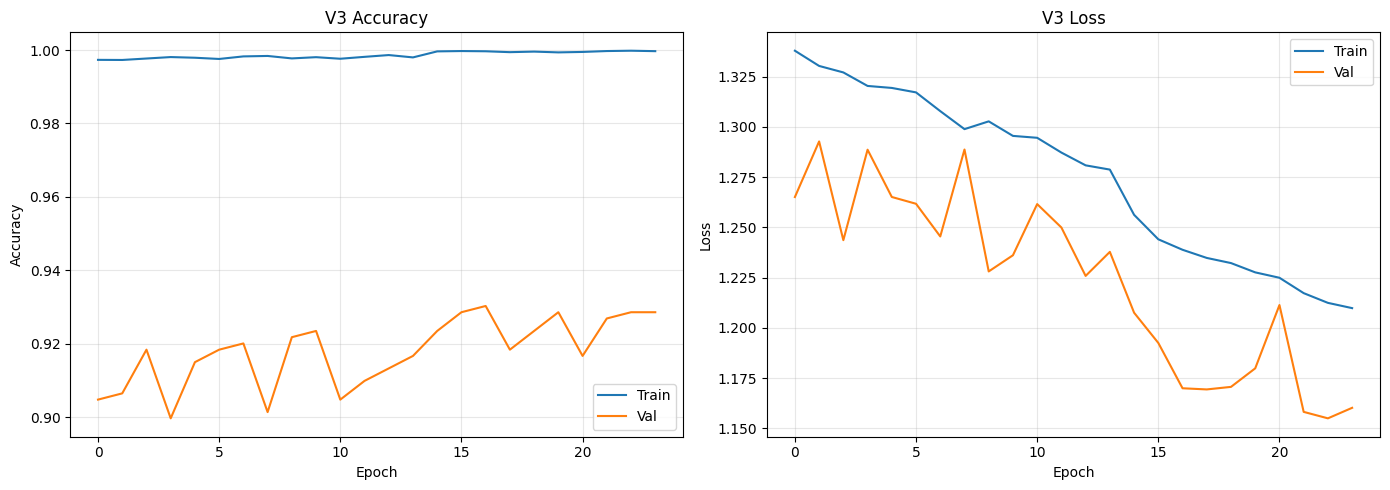


Best val_accuracy: 0.9303
Best val_loss: 1.1550
Total epochs: 24


In [10]:
import matplotlib.pyplot as plt

# ── Handle case where history is not defined (interrupted training / resumed session) ──
if 'history' not in dir() or history is None:
    print("⚠️  No training history in memory (training was interrupted or this is a resumed session)")
    print("   Skipping training plots — proceed to Cell 7 for evaluation")
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title('V3 Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title('V3 Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/training_history_v3.png', dpi=150)
    plt.show()

    print(f"\nBest val_accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Best val_loss: {min(history.history['val_loss']):.4f}")
    print(f"Total epochs: {len(history.history['loss'])}")

## Cell 7: Evaluation — Classification Report + Confusion Matrix + Per-Speed Accuracy (Held-Out Test Set)

**V3.1.4:** Also evaluates the model on simulated speed variants of the test set.
The test set itself was NOT speed-augmented — this checks generalization to unseen speeds.

📂 Loading best model from Drive: /content/drive/MyDrive/iSuara/v3_best.keras

Evaluating on held-out test set (588 samples)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step

🎯 V3.1.5 Test Accuracy (held-out, 1× speed): 0.9116 (91.2%)
   Train Accuracy: 1.0000 (100.0%)
   Val Accuracy:   0.9303 (93.0%)
   Test Accuracy:  0.9116 (91.2%)
   Generalization gap (train - test): 8.8%  ⚠️ >2%

CLASSIFICATION REPORT (1× speed)
                  precision    recall  f1-score   support

       Sama-sama       1.00      1.00      1.00         6
         Sekolah       1.00      1.00      1.00         6
             Ada       1.00      1.00      1.00         6
           Duduk       1.00      1.00      1.00         6
            Maaf       0.86      1.00      0.92         6
         Gembira       1.00      1.00      1.00         6
          Mereka       1.00      1.00      1.00         6
           Rumah       1.00      1.00      1.00         6
           Panas       0.86      1.00      0.92         6
  

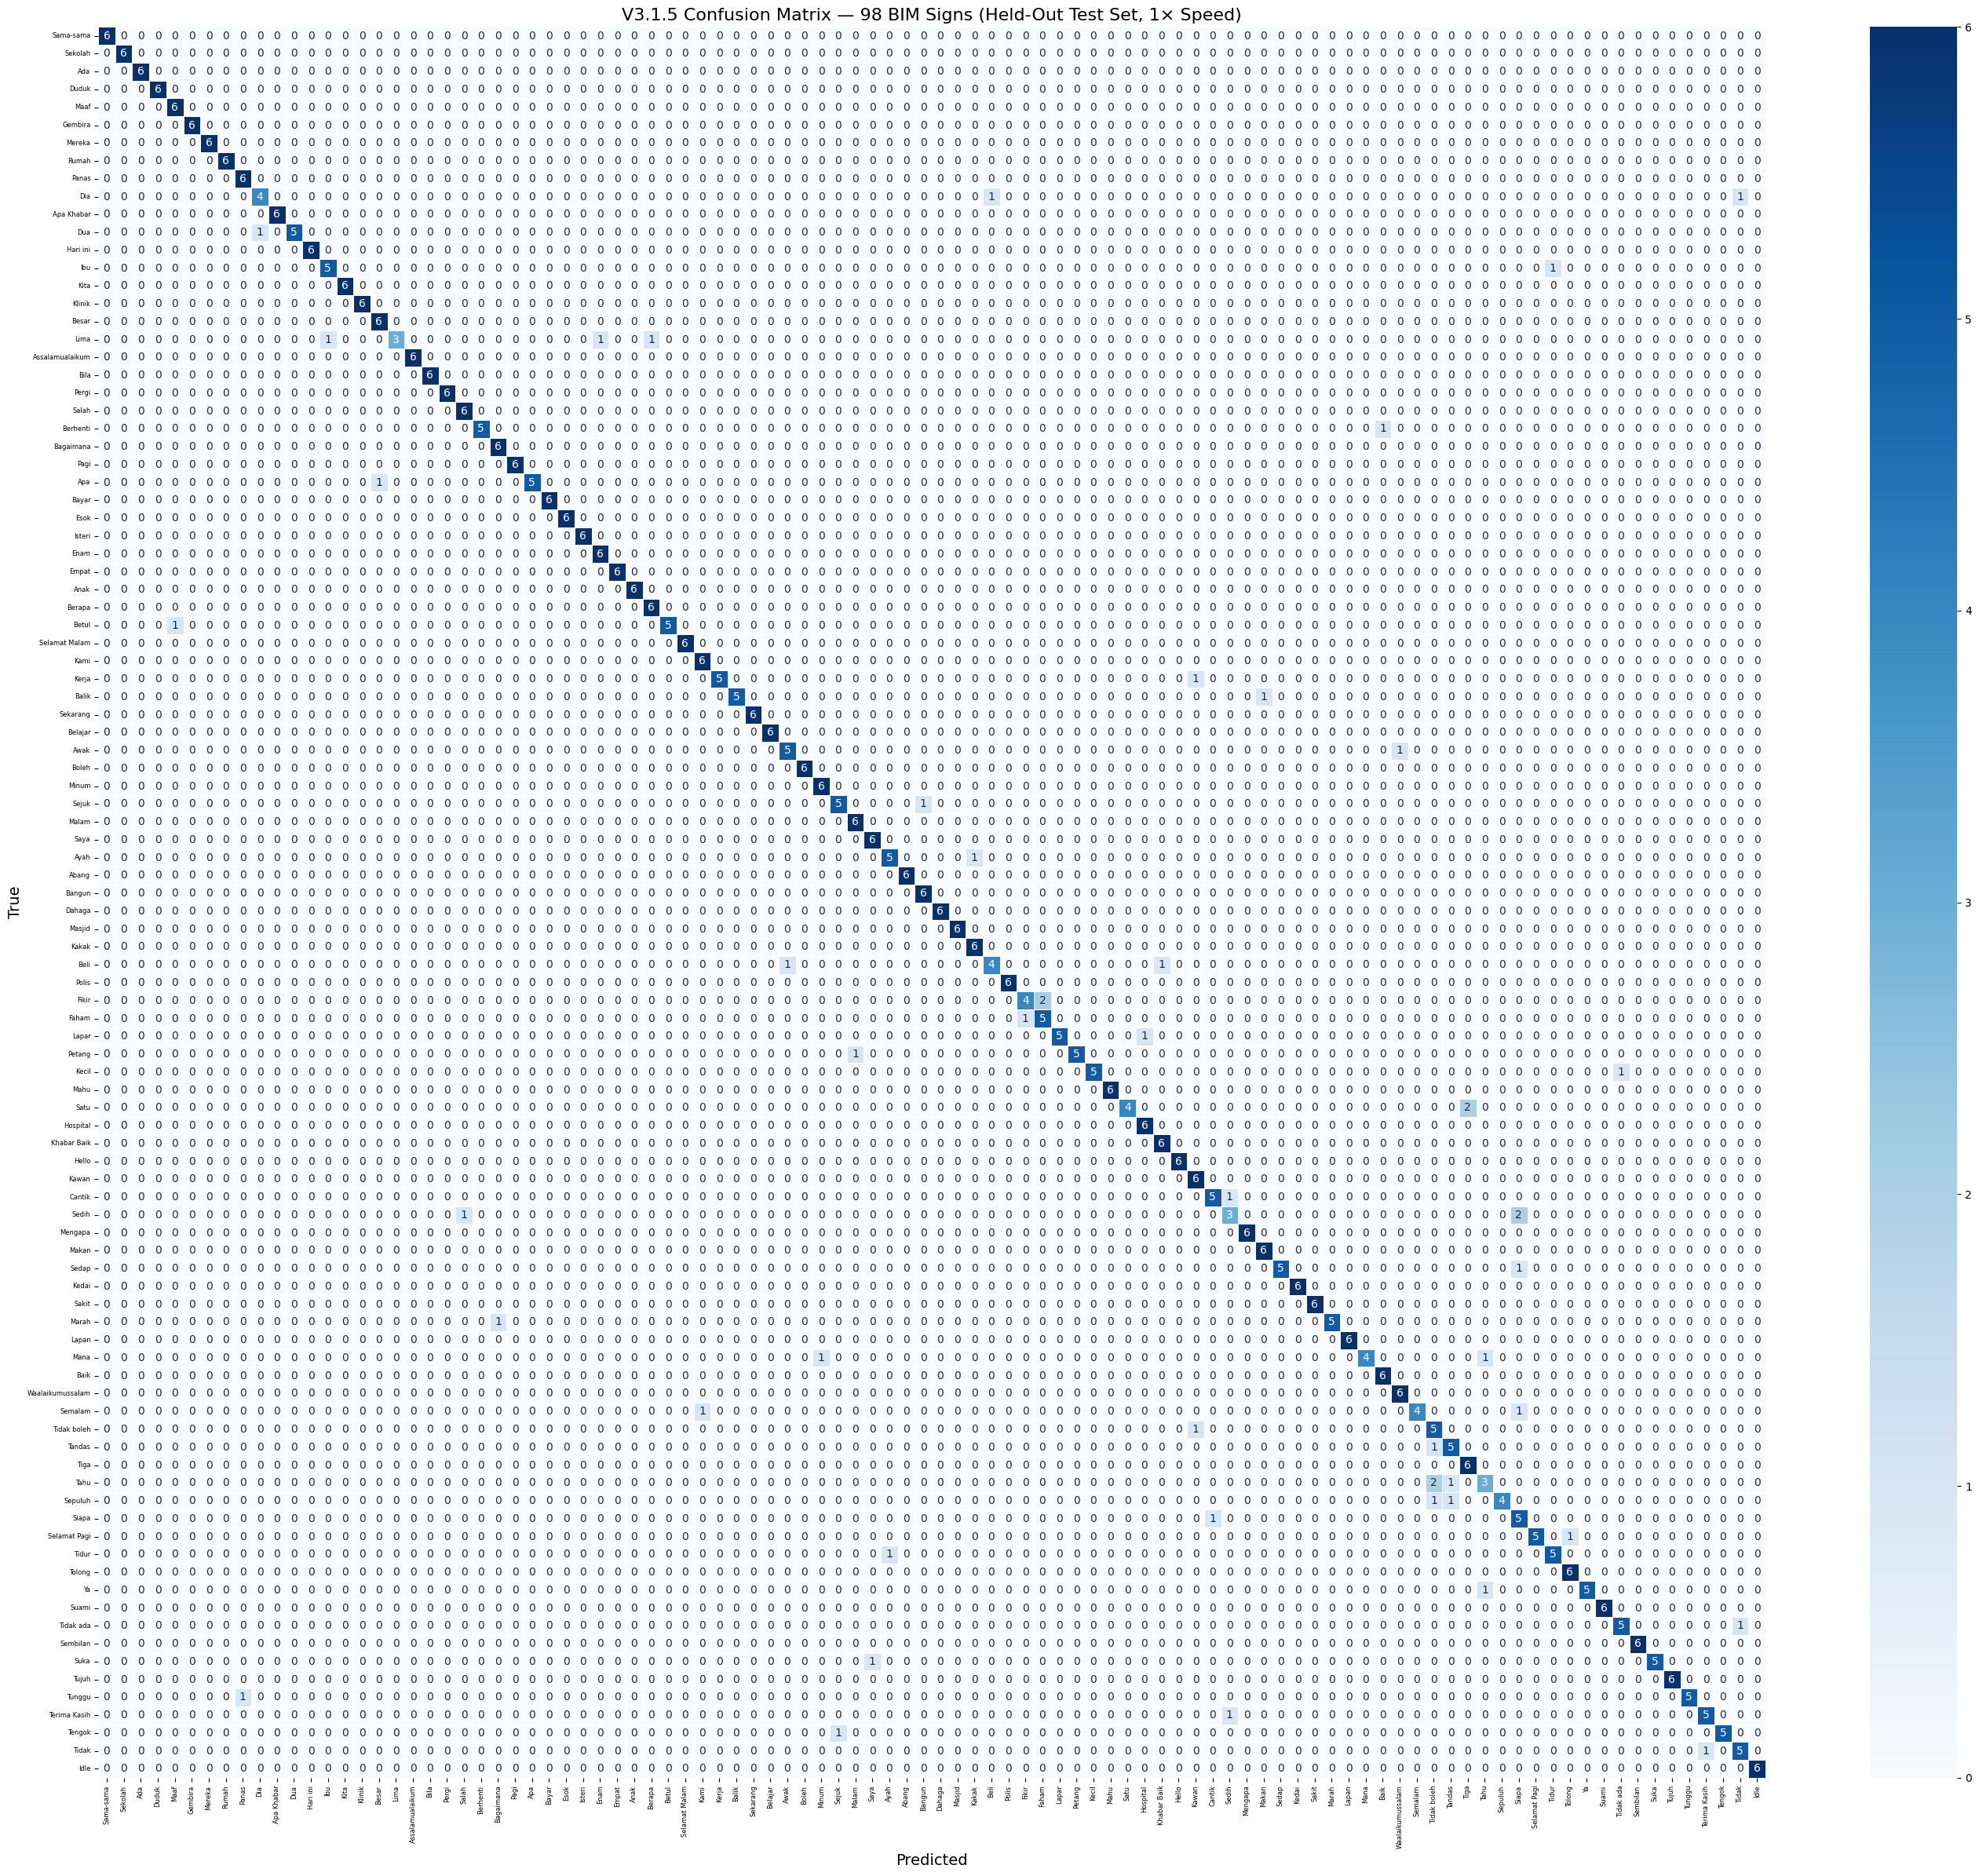


V3.1.5 PER-SPEED ACCURACY TABLE (held-out test set)

Speed    Frames   Accuracy     Status
──────── ──────── ──────────── ──────────
1×       30       91.2%       ✅
1.5×     20       91.5%       ✅
2×       15       90.1%       ✅

Avg      ─        90.9%

📊 V3.1.5 Summary: 91.2% test accuracy (1× speed) with 1,374,883 params
   Multi-speed average: 90.9%
   Generalization gap: 8.8%


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns

# ── Load best model: prefer Drive checkpoint (survives session restarts) ──
DRIVE_BEST = '/content/drive/MyDrive/iSuara/v3_best.keras'
LOCAL_BEST = '/content/best_model_v3.keras'

if os.path.exists(DRIVE_BEST):
    print(f"📂 Loading best model from Drive: {DRIVE_BEST}")
    best_model = tf.keras.models.load_model(DRIVE_BEST)
elif os.path.exists(LOCAL_BEST):
    print(f"📂 Loading best model from local: {LOCAL_BEST}")
    best_model = tf.keras.models.load_model(LOCAL_BEST)
else:
    print("📂 Using in-memory model (EarlyStopping restore_best_weights)")
    best_model = model

# ══════════════════════════════════════════════════════════════
# STANDARD EVALUATION (full-sequence, 1× speed)
# ══════════════════════════════════════════════════════════════

print(f"\nEvaluating on held-out test set ({X_test.shape[0]} samples)...")
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

overall_acc = accuracy_score(y_true, y_pred)
print(f"\n🎯 V3.1.5 Test Accuracy (held-out, 1× speed): {overall_acc:.4f} ({overall_acc*100:.1f}%)")

# Also report train & val accuracy for overfitting comparison
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
print(f"   Train Accuracy: {train_acc:.4f} ({train_acc*100:.1f}%)")
print(f"   Val Accuracy:   {val_acc:.4f} ({val_acc*100:.1f}%)")
print(f"   Test Accuracy:  {overall_acc:.4f} ({overall_acc*100:.1f}%)")
gap = train_acc - overall_acc
print(f"   Generalization gap (train - test): {gap*100:.1f}%  {'✅ <2%' if gap < 0.02 else '⚠️ >2%'}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT (1× speed)")
print("=" * 60)
report = classification_report(y_true, y_pred, target_names=ACTIONS, zero_division=0)
print(report)

per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
worst_indices = np.argsort(per_class_f1)[:10]
print("\n⚠️  10 Worst Classes:")
for idx in worst_indices:
    print(f"   {ACTIONS[idx]}: F1={per_class_f1[idx]:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(28, 24))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIONS, yticklabels=ACTIONS, ax=ax, linewidths=0.5)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('True', fontsize=14)
ax.set_title('V3.1.5 Confusion Matrix — 98 BIM Signs (Held-Out Test Set, 1× Speed)', fontsize=16)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.savefig('/content/confusion_matrix_v3.png', dpi=150)
plt.show()

# ══════════════════════════════════════════════════════════════
# PER-SPEED EVALUATION TABLE
# ══════════════════════════════════════════════════════════════
# Simulate speed variants on the HELD-OUT test set (which was NOT
# speed-augmented) to verify the model generalizes to unseen speeds.

print("\n" + "=" * 60)
print("V3.1.5 PER-SPEED ACCURACY TABLE (held-out test set)")
print("=" * 60)

speed_results = [("1×", 30, overall_acc)]

test_speed_tiers = [
    ("1.5×", 20),
    ("2×",   15),
]

for speed_name, num_frames in test_speed_tiers:
    # Downsample raw test data at this speed tier
    if num_frames == 20:
        indices = np.round(np.linspace(0, 29, num_frames)).astype(int)
    elif num_frames == 15:
        indices = np.arange(0, 30, 2)
    elif num_frames == 10:
        indices = np.arange(0, 30, 3)
    else:
        indices = np.round(np.linspace(0, 29, num_frames)).astype(int)

    # Downsample from RAW test data + hold-pad
    X_test_speed_raw = X_test_raw[:, indices, :]  # (N, num_frames, 258)
    pad_length = 30 - num_frames
    if pad_length > 0:
        last_frame = X_test_speed_raw[:, -1:, :]
        padding = np.tile(last_frame, (1, pad_length, 1))
        X_test_speed_raw = np.concatenate([X_test_speed_raw, padding], axis=1)

    # Apply Stages 1-5
    X_test_speed_norm = apply_stages_1_to_5(X_test_speed_raw)

    # Apply z-score using saved SCALER_MEAN / SCALER_SCALE (in-place)
    X_test_speed_norm -= SCALER_MEAN
    X_test_speed_norm /= SCALER_SCALE
    X_test_speed_z = X_test_speed_norm

    # Predict
    y_pred_speed = np.argmax(best_model.predict(X_test_speed_z, verbose=0), axis=1)
    speed_acc = accuracy_score(y_true, y_pred_speed)
    speed_results.append((speed_name, num_frames, speed_acc))

# Print table
print(f"\n{'Speed':<8} {'Frames':<8} {'Accuracy':<12} {'Status'}")
print(f"{'─'*8} {'─'*8} {'─'*12} {'─'*10}")
for speed_name, num_frames, acc in speed_results:
    status = "✅" if acc >= 0.85 else ("⚠️" if acc >= 0.70 else "❌")
    print(f"{speed_name:<8} {num_frames:<8} {acc*100:.1f}%{'':>6} {status}")

# Overall multi-speed average
avg_acc = np.mean([r[2] for r in speed_results])
print(f"\n{'Avg':<8} {'─':<8} {avg_acc*100:.1f}%")

print(f"\n📊 V3.1.5 Summary: {overall_acc*100:.1f}% test accuracy (1× speed) with {best_model.count_params():,} params")
print(f"   Multi-speed average: {avg_acc*100:.1f}%")
print(f"   Generalization gap: {gap*100:.1f}%")

## Cell 8: Export — TFLite with Baked Scaler + Int8 Quantization (TF 2.16.1 / Keras 3)

**Key features:**
1. **Scaler baked into model** — z-score as `tf.constant` arithmetic → no `scaler.save` at inference
2. **CPU subprocess** — forces standard LSTM ops (not CuDNN) for TFLite compatibility
3. **3 fallback conversion approaches** — guarantees at least one succeeds:
   - Approach 1: `model.export()` → `from_saved_model` (**PRIMARY** — only path that works on TF 2.16.1)
   - Approach 2: `from_saved_model` + `SELECT_TF_OPS` (if built-in ops insufficient)
   - Approach 3: `from_keras_model` (last resort — broken on TF 2.16.1 but kept for other TF versions)
4. **No custom layers** — `Dot` attention converts cleanly without registration
5. **Float32 + Dynamic-range Int8** (weights int8, activations float32 — avoids LSTM C-level crash)

**TF 2.16.1 / Keras 3 compatibility notes:**
- `from_concrete_functions` → BROKEN with LSTMs (int64 vs resource state variable error) — **removed**
- `from_keras_model` → BROKEN (`'Functional' object has no attribute '_get_save_spec'`) — **demoted to last resort**
- `model.export()` → `from_saved_model` → **WORKS** ✅ — promoted to primary approach for both f32 and int8

In [12]:
# ═══════════════════════════════════════════════════════════════════
# V3.1.5 TFLite Export (same conversion as V3.1.2, updated metadata)
# ═══════════════════════════════════════════════════════════════════
# PROBLEM: TF 2.16.1 + Keras 3 broke the original TFLite export:
#   1. from_concrete_functions crashes on LSTMs (int64 vs resource
#      state variable type mismatch — Keras 3 changed internal repr)
#   2. from_keras_model crashes with '_get_save_spec' AttributeError
#      (Keras 3 Functional model removed this internal method)
#   3. model.save(path) without .keras/.h5 extension is rejected
#
# FIX — All conversion now uses model.export() → from_saved_model
# as the PRIMARY method (the only path that works on TF 2.16.1):
#
#   Float32 subprocess:
#     Approach 1: model.export() → from_saved_model   (PRIMARY)
#     Approach 2: + SELECT_TF_OPS                     (fallback)
#     Approach 3: from_keras_model                    (last resort)
#
#   Int8 subprocess:
#     Approach 1: model.export() → from_saved_model + dynamic-range
#     Approach 2: + SELECT_TF_OPS + dynamic-range     (fallback)
#     Approach 3: + SELECT_TF_OPS + float16           (fallback)
#
# NOTE: Full int8 quantization (representative_dataset +
#   TFLITE_BUILTINS_INT8) is NOT used — it causes a C-level segfault
#   in LSTM quantization. Dynamic-range quantization (weights int8,
#   activations float32) is used instead — still ~2× smaller than f32.
# ═══════════════════════════════════════════════════════════════════

import json
import shutil
import subprocess
import sys

OUTPUT_DIR = '/content/isuara_model_v3'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Ensure SCALER_MEAN/SCALER_SCALE exist (may need loading from Drive in resumed session) ──
if 'SCALER_MEAN' not in dir():
    drive_mean = '/content/drive/MyDrive/iSuara/scaler_mean_v3.npy'
    drive_scale = '/content/drive/MyDrive/iSuara/scaler_scale_v3.npy'
    if os.path.exists(drive_mean) and os.path.exists(drive_scale):
        SCALER_MEAN = np.load(drive_mean)
        SCALER_SCALE = np.load(drive_scale)
        print(f"📂 Loaded scaler from Drive")
    else:
        raise RuntimeError("SCALER_MEAN/SCALER_SCALE not found! Re-run Cells 1-3 first.")

# ── Ensure best_model exists ──
if 'best_model' not in dir():
    DRIVE_BEST = '/content/drive/MyDrive/iSuara/v3_best.keras'
    LOCAL_BEST = '/content/best_model_v3.keras'
    if os.path.exists(DRIVE_BEST):
        best_model = tf.keras.models.load_model(DRIVE_BEST)
        print(f"📂 Loaded best_model from Drive")
    elif os.path.exists(LOCAL_BEST):
        best_model = tf.keras.models.load_model(LOCAL_BEST)
        print(f"📂 Loaded best_model from local")
    else:
        raise RuntimeError("No best_model found! Run Cell 7 first.")

# ─────────────────────────────────────────────────────────────
# BUILD EXPORT MODEL WITH BAKED-IN SCALER
# ─────────────────────────────────────────────────────────────

print("══ Building export model with baked-in scaler...")

export_input = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), dtype=tf.float32, name='raw_input')

# Bake z-score: (x - mean) / std using tf.constant
scaler_mean_const = tf.constant(SCALER_MEAN.reshape(1, 1, NUM_FEATURES), dtype=tf.float32)
scaler_scale_const = tf.constant(SCALER_SCALE.reshape(1, 1, NUM_FEATURES), dtype=tf.float32)
normalized = (export_input - scaler_mean_const) / scaler_scale_const

export_output = best_model(normalized)
export_model = Model(inputs=export_input, outputs=export_output, name='iSuara_V3_export')
export_model.summary()

# ── Sanity check ──
test_sample_raw = X_test[:1]
test_sample_unnormed = (test_sample_raw.reshape(-1, NUM_FEATURES) * SCALER_SCALE + SCALER_MEAN).reshape(1, SEQUENCE_LENGTH, NUM_FEATURES)

pred_original = best_model.predict(test_sample_raw, verbose=0)
pred_export = export_model.predict(test_sample_unnormed.astype(np.float32), verbose=0)

print(f"\nSanity check:")
print(f"  Original: {ACTIONS[np.argmax(pred_original)]} ({pred_original.max():.4f})")
print(f"  Export:   {ACTIONS[np.argmax(pred_export)]} ({pred_export.max():.4f})")
diff = np.abs(pred_original - pred_export).max()
print(f"  Max diff: {diff:.6f}")
assert diff < 0.01, f"Export model diverges! diff={diff}"
print("  ✅ Export model verified!")

# ─────────────────────────────────────────────────────────────
# SAVE ARTIFACTS FOR SUBPROCESS
# ─────────────────────────────────────────────────────────────

kera_path = os.path.join(OUTPUT_DIR, 'bim_lstm_v3.keras')
export_model.save(kera_path)
print(f"\n✅ Keras saved: {kera_path} ({os.path.getsize(kera_path)/(1024*1024):.1f} MB)")

# Save inner model weights separately (for clean CPU rebuild in subprocess)
inner_weights_path = '/content/inner_weights_v3.weights.h5'
best_model.save_weights(inner_weights_path)
print(f"✅ Inner model weights saved")

# Save scaler arrays
np.save('/content/scaler_mean_v3.npy', SCALER_MEAN)
np.save('/content/scaler_scale_v3.npy', SCALER_SCALE)

# Save un-normalized test data for int8 calibration
X_test_unnormed = (X_test.reshape(-1, NUM_FEATURES) * SCALER_SCALE + SCALER_MEAN).reshape(
    X_test.shape[0], SEQUENCE_LENGTH, NUM_FEATURES
).astype(np.float32)
np.save('/content/repr_data_v3.npy', X_test_unnormed[:200])

# ─────────────────────────────────────────────────────────────
# TFLITE CONVERSION ─ FLOAT32 SUBPROCESS (separate from int8)
# ─────────────────────────────────────────────────────────────
#
# Float32 and Int8 are done in SEPARATE subprocesses so that
# a C-level crash during int8 quantization doesn't lose the f32 model.
#
#   - from_concrete_functions → BROKEN (int64 vs resource on LSTM states)
#   - from_keras_model → BROKEN ('Functional' has no '_get_save_spec')
#   - model.export() → from_saved_model → WORKS ✅ (primary approach)
#   - model.export() creates SavedModel for from_saved_model fallback

print("\n══ Converting to TFLite (CPU subprocess)...")

# ── Shared model-building code for both scripts ──
SHARED_MODEL_CODE = r'''
import os, sys, traceback
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization,
    Bidirectional, Softmax, Flatten, Reshape, Multiply, Dot,
    GaussianNoise, SpatialDropout1D
)
from tensorflow.keras import regularizers
import shutil

# Parse arguments for subprocess
weights_path = sys.argv[1]
output_dir = sys.argv[2]
repr_data_path = sys.argv[3]
seq_len = int(sys.argv[4])
num_feat = int(sys.argv[5])
num_classes = int(sys.argv[6])
mean_path = sys.argv[7]
scale_path = sys.argv[8]

def build_inner_model(seq_len, num_feat, num_classes, unroll):
    """Build the V3.1 inner model (matches Cell 4 architecture exactly)."""
    L2_REG = 3e-4
    inputs = Input(shape=(seq_len, num_feat), name='input')
    x = GaussianNoise(0.05, name='noise')(inputs)
    x = SpatialDropout1D(0.1, name='spatial_drop')(x)
    x = Bidirectional(LSTM(128, return_sequences=True, unroll=unroll,
        recurrent_dropout=0.25,
        kernel_regularizer=regularizers.l2(L2_REG),
        recurrent_regularizer=regularizers.l2(L2_REG)), name='bilstm_1')(x)
    x = BatchNormalization(name='bn_1')(x)
    x = Dropout(0.4, name='drop_1')(x)
    x = Bidirectional(LSTM(128, return_sequences=True, unroll=unroll,
        recurrent_dropout=0.25,
        kernel_regularizer=regularizers.l2(L2_REG),
        recurrent_regularizer=regularizers.l2(L2_REG)), name='bilstm_2')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(0.4, name='drop_2')(x)
    attn_scores = Dense(1, activation='tanh', name='attn_score')(x)
    attn_scores = Flatten(name='attn_flatten')(attn_scores)
    attn_weights = Softmax(name='attn_softmax')(attn_scores)
    attn_T = Reshape((1, seq_len), name='attn_T')(attn_weights)
    context = Dot(axes=(2, 1), name='attn_dot')([attn_T, x])
    context = Reshape((256,), name='context_squeeze')(context)
    x = Dense(128, activation='relu', name='dense_1',
        kernel_regularizer=regularizers.l2(L2_REG))(context)
    x = Dropout(0.5, name='drop_3')(x)
    x = Dense(64, activation='relu', name='dense_2',
        kernel_regularizer=regularizers.l2(L2_REG))(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    return Model(inputs=inputs, outputs=outputs, name='iSuara_V3_BiLSTM_Attn')

def build_export_model(inner_model, seq_len, num_feat, mean_path, scale_path):
    """Wrap inner model with baked-in z-score scaler."""
    scaler_mean = np.load(mean_path)
    scaler_scale = np.load(scale_path)
    export_input = Input(shape=(seq_len, num_feat), dtype=tf.float32, name='raw_input')
    mean_const = tf.constant(scaler_mean.reshape(1, 1, num_feat), dtype=tf.float32)
    scale_const = tf.constant(scaler_scale.reshape(1, 1, num_feat), dtype=tf.float32)
    normalized = (export_input - mean_const) / scale_const
    export_output = inner_model(normalized)
    return Model(inputs=export_input, outputs=export_output, name='iSuara_V3_export')
'''

# ─────────────────────────────────────────────────────────────
# PRIMARY: model.export() → from_saved_model (only working path
# on TF 2.16.1 — from_keras_model hits '_get_save_spec' error)
# ─────────────────────────────────────────────────────────────
f32_script = SHARED_MODEL_CODE + r'''

try:
    print(f"  TF version: {tf.__version__}", flush=True)

    # Build model on CPU
    inner_model = build_inner_model(seq_len, num_feat, num_classes, unroll=False)
    inner_model.load_weights(weights_path)
    export_model = build_export_model(inner_model, seq_len, num_feat, mean_path, scale_path)
    print(f"  Export model ready. Params: {export_model.count_params():,}", flush=True)

    # Export to SavedModel once (reused across approaches)
    saved_model_path = os.path.join(output_dir, 'temp_export_saved_model')
    if os.path.exists(saved_model_path):
        shutil.rmtree(saved_model_path)
    export_model.export(saved_model_path)
    print(f"  Exported SavedModel to: {saved_model_path}", flush=True)

    # APPROACH 1: from_saved_model (PRIMARY — works on TF 2.16.1)
    print("\n  === APPROACH 1: from_saved_model ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_f32 = converter.convert()
        f32_path = os.path.join(output_dir, 'bim_lstm_v3_f32.tflite')
        with open(f32_path, 'wb') as f:
            f.write(tflite_f32)
        print(f"  ✅ Float32: {os.path.getsize(f32_path)/1024:.0f} KB", flush=True)
        shutil.rmtree(saved_model_path)
        sys.exit(0)
    except Exception as e1:
        print(f"  ☢️ Approach 1 failed: {e1}", flush=True)

    # APPROACH 2: from_saved_model + SELECT_TF_OPS (if built-in ops insufficient)
    print("\n  === APPROACH 2: from_saved_model + SELECT_TF_OPS ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
        ]
        tflite_f32 = converter.convert()
        f32_path = os.path.join(output_dir, 'bim_lstm_v3_f32.tflite')
        with open(f32_path, 'wb') as f:
            f.write(tflite_f32)
        print(f"  ✅ Float32: {os.path.getsize(f32_path)/1024:.0f} KB", flush=True)
        shutil.rmtree(saved_model_path)
        sys.exit(0)
    except Exception as e2:
        print(f"  ☢️ Approach 2 failed: {e2}", flush=True)
        print(f"  Exported SavedModel to: {saved_model_path}", flush=True)
    # APPROACH 3: from_keras_model (last resort — may not work on TF 2.16.1)
    print("\n  === APPROACH 3: from_keras_model (last resort) ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(export_model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False
        tflite_f32 = converter.convert()
        f32_path = os.path.join(output_dir, 'bim_lstm_v3_f32.tflite')
        with open(f32_path, 'wb') as f:
            f.write(tflite_f32)
        print(f"  ✅ Float32: {os.path.getsize(f32_path)/1024:.0f} KB", flush=True)
        sys.exit(0)
    except Exception as e3:
        print(f"  ❌ Approach 3 failed: {e3}", flush=True)
        sys.exit(1)
    finally:
        if os.path.exists(saved_model_path):
            shutil.rmtree(saved_model_path)

except Exception as e:
    traceback.print_exc()
    sys.exit(1)
'''
f32_script_path = '/content/convert_f32_v3.py'
with open(f32_script_path, 'w') as f:
    f.write(f32_script)

subprocess_args = [
    sys.executable, f32_script_path,
    inner_weights_path, OUTPUT_DIR, '/content/repr_data_v3.npy',
    str(SEQUENCE_LENGTH), str(NUM_FEATURES), str(NUM_CLASSES),
    '/content/scaler_mean_v3.npy', '/content/scaler_scale_v3.npy'
]
subprocess_env = {**os.environ, 'CUDA_VISIBLE_DEVICES': ''}
# Corrected: Move the print(result_f32.stdout) after the subprocess.run call
print("── Float32 conversion ──")
result_f32 = subprocess.run(subprocess_args, capture_output=True, text=True, env=subprocess_env)
print(result_f32.stdout)

tflite_f32_path = os.path.join(OUTPUT_DIR, 'bim_lstm_v3_f32.tflite')
if not os.path.exists(tflite_f32_path):
    print("STDERR (last 2000 chars):")
    print(result_f32.stderr[-2000:])
    raise RuntimeError("Float32 TFLite conversion failed! All 3 approaches exhausted.")
# PRIMARY: model.export() → from_saved_model + dynamic-range
# quantization (weights int8, activations float32).
# Avoids: from_keras_model ('_get_save_spec' error on TF 2.16.1)
#         full int8 (C-level segfault on LSTM quantization)
# ─────────────────────────────────────────────────────────────
# to avoid C-level crash on full int8 LSTM quantization.
int8_script = SHARED_MODEL_CODE + r'''

try:
    print(f"  TF version: {tf.__version__}", flush=True)

    inner_model = build_inner_model(seq_len, num_feat, num_classes, unroll=False)
    inner_model.load_weights(weights_path)
    export_model = build_export_model(inner_model, seq_len, num_feat, mean_path, scale_path)
    print(f"  Export model ready. Params: {export_model.count_params():,}", flush=True)

    # Export to SavedModel once (reused across approaches)
    saved_model_path = os.path.join(output_dir, 'temp_export_saved_model_int8')
    if os.path.exists(saved_model_path):
        shutil.rmtree(saved_model_path)
    export_model.export(saved_model_path)
    print(f"  Exported SavedModel to: {saved_model_path}", flush=True)

    # ── APPROACH 1: from_saved_model + dynamic-range quantization ──
    # NO representative_dataset ─ avoids C-level crash on LSTM quantization
    # NO TFLITE_BUILTINS_INT8 ─ that forces full int8 which LSTMs don't support
    print("\n  === APPROACH 1: from_saved_model + dynamic-range ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_int8 = converter.convert()
        int8_path = os.path.join(output_dir, 'bim_lstm_v3_int8.tflite')
        with open(int8_path, 'wb') as f:
            f.write(tflite_int8)
        print(f"  ✅ Dynamic-range quantized: {os.path.getsize(int8_path)/1024:.0f} KB", flush=True)
        shutil.rmtree(saved_model_path)
        sys.exit(0)
    except Exception as e1:
        print(f"  ☢️ Approach 1 failed: {e1}", flush=True)

    # ── APPROACH 2: from_saved_model + SELECT_TF_OPS + dynamic-range ──
    print("\n  === APPROACH 2: from_saved_model + SELECT_TF_OPS + dynamic-range ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
        ]
        tflite_int8 = converter.convert()
        int8_path = os.path.join(output_dir, 'bim_lstm_v3_int8.tflite')
        with open(int8_path, 'wb') as f:
            f.write(tflite_int8)
        print(f"  ✅ Dynamic-range quantized: {os.path.getsize(int8_path)/1024:.0f} KB", flush=True)
        shutil.rmtree(saved_model_path)
        sys.exit(0)
    except Exception as e2:
        print(f"  ☢️ Approach 2 failed: {e2}", flush=True)

    # ── APPROACH 3: from_saved_model + SELECT_TF_OPS + float16 ──
    print("\n  === APPROACH 3: from_saved_model + float16 ===", flush=True)
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
        ]
        tflite_int8 = converter.convert()
        int8_path = os.path.join(output_dir, 'bim_lstm_v3_int8.tflite')
        with open(int8_path, 'wb') as f:
            f.write(tflite_int8)
        print(f"  ✅ Float16 quantized: {os.path.getsize(int8_path)/1024:.0f} KB", flush=True)
        shutil.rmtree(saved_model_path)
        sys.exit(0)
    except Exception as e3:
        print(f"  ❌ All quantization approaches failed: {e3}", flush=True)
        if os.path.exists(saved_model_path):
            shutil.rmtree(saved_model_path)
        sys.exit(1)

except Exception as e:
    traceback.print_exc()
    sys.exit(1)
'''

int8_script_path = '/content/convert_int8_v3.py'
with open(int8_script_path, 'w') as f:
    f.write(int8_script)

print("\n── Int8 conversion (separate subprocess ─ won't affect f32) ──")
result_int8 = subprocess.run(
    [sys.executable, int8_script_path] + subprocess_args[2:],
    capture_output=True, text=True, env=subprocess_env
)
print(result_int8.stdout)

tflite_int8_path = os.path.join(OUTPUT_DIR, 'bim_lstm_v3_int8.tflite')
if os.path.exists(tflite_int8_path):
    print(f"✅ Int8 TFLite: {os.path.getsize(tflite_int8_path)/1024:.0f} KB")
else:
    tflite_int8_path = None
    print("☢️ Int8 conversion failed (non-critical ─ float32 model is available)")
    if result_int8.stderr:
        print("  STDERR (last 1000 chars):")
        print(result_int8.stderr[-1000:])

# ─────────────────────────────────────────────────────────────
# SAVE LABEL MAP + NORMALIZE_FRAME.PY
# ─────────────────────────────────────────────────────────────

label_map_path = os.path.join(OUTPUT_DIR, 'label_map.json')
label_data = {
    'actions_ordered': ACTIONS,
    'action_to_index': label_map,
    'index_to_action': {str(v): k for k, v in label_map.items()},
    'num_classes': NUM_CLASSES,
    'sequence_length': SEQUENCE_LENGTH,
    'num_features': NUM_FEATURES,
    'num_raw_features': NUM_RAW_FEATURES,
    'model_version': 'V3.1.5',
    'scaler_baked_in': True,
    'multi_speed_trained': True,
    'speed_tiers': ['1x', '1.5x', '2x'],
    'idle_prefix_augmented': False,
        'zscore_fitted_on': '1x_speed_only',
    'architecture': '2x BiLSTM-128 + Dot Attention',
    'processing_pipeline': {
        'stages': [
            'Stage 1: Anchor subtraction (pose→shoulder midpoint, hands→wrist)',
            'Stage 2: Scale by shoulder width',
            'Stage 3: Velocity (1st derivative, +258 → 516)',
            'Stage 4: Acceleration (2nd derivative, +258 → 774)',
            'Stage 5: Engineered features (+6 → 780)',
            'Stage 6: Z-score (BAKED INTO MODEL ─ no external scaler needed!)',
        ],
        'note': 'Apply stages 1-5 externally. Stage 6 is inside the TFLite model.',
        'input_to_model': '(1, 30, 780) float32 ─ stages 1-5 applied, NO z-score needed',
        'training_pipeline_order': 'Split → Speed variants → Stages 1-5 → Augment → Z-score (fitted on 1× only)',
    }
}
with open(label_map_path, 'w', encoding='utf-8') as f:
    json.dump(label_data, f, ensure_ascii=False, indent=2)
print(f"\n✅ Label map: {label_map_path}")

normalize_code = r'''"""
normalize_frame.py (V3) ─ Stages 1-5 only.
Stage 6 (z-score) is BAKED INTO the TFLite model ─ no scaler needed!

Usage:
    from normalize_frame import normalize_single_frame, build_sequence_features

    raw_buffer = []

    # Per frame:
    kp = extract_keypoints(results)              # (258,)
    kp = normalize_single_frame(kp)              # (258,) stages 1+2
    raw_buffer.append(kp)
    # When 30 frames ready:
    seq = np.array(raw_buffer[-30:])             # (30, 258)
    seq = build_sequence_features(seq)           # (30, 780) stages 3+4+5
    # Feed directly to model ─ NO scaler.transform() needed!
    interpreter.set_tensor(input_idx, seq[np.newaxis].astype(np.float32))
    interpreter.invoke()
    pred = interpreter.get_tensor(output_idx)    # (1, 98)
"""
import numpy as np

def normalize_single_frame(frame):
    """
    Stage 1 (Anchor) + Stage 2 (Scale) for ONE frame.
    # ── Stage 1: Anchor Subtraction ──
    Args:
        frame: np.array shape (258,) ─ raw from extract_keypoints()
    Returns:
        np.array shape (258,) ─ anchor + scale normalized
    """
    frame = frame.copy().astype(np.float64)

    # ── Stage 1: Anchor Subtraction ──
    shoulder_l = frame[44:47]
    shoulder_r = frame[48:51]
    pose_anchor = (shoulder_l + shoulder_r) / 2.0

    # Pose: subtract anchor from xyz of all 33 landmarks
    if np.any(pose_anchor != 0):
        pose_xyz = frame[:132].reshape(33, 4)[:, :3]  # view of xyz only
        frame[:132].reshape(33, 4)[:, :3] -= pose_anchor  # broadcasting: (33, 3) -= (3,) → CORRECT

    # Left hand: anchor to wrist
    lh_wrist = frame[132:135].copy()
    if np.any(lh_wrist != 0):
        frame[132:195].reshape(21, 3) -= lh_wrist

    # Right hand: anchor to wrist
    rh_wrist = frame[195:198].copy()
    if np.any(rh_wrist != 0):
        frame[195:258].reshape(21, 3) -= rh_wrist

    # ── Stage 2: Scale by Shoulder Width ──
    shoulder_width = np.linalg.norm(shoulder_l - shoulder_r)

    if shoulder_width > 0.01:
        frame[:132].reshape(33, 4)[:, :3] /= shoulder_width
        frame[132:195] /= shoulder_width
        frame[195:258] /= shoulder_width

    return frame

def build_sequence_features(sequence):
    """
    Stages 3 + 4 + 5 for a full 30-frame sequence.

    Args:
        sequence: np.array shape (30, 258) ─ anchor+scale normalized
    Returns:
        np.array shape (30, 780) ─ [position | velocity | acceleration | engineered]
    """
    T = sequence.shape[0]

    # Stage 3: Velocity
    velocity = np.zeros_like(sequence)
    velocity[1:] = sequence[1:] - sequence[:-1]

    # Stage 4: Acceleration
    acceleration = np.zeros_like(velocity)
    acceleration[1:] = velocity[1:] - velocity[:-1]

    # Stage 5: Engineered features
    engineered = np.zeros((T, 6))
    lw = sequence[:, 60:63]   # left wrist xyz
    rw = sequence[:, 64:67]   # right wrist xyz
    nose = sequence[:, 0:3]   # nose xyz
    engineered[:, 0] = np.linalg.norm(lw - rw, axis=1)
    engineered[:, 1:4] = lw - rw
    engineered[:, 4] = np.linalg.norm(lw - nose, axis=1)
    engineered[:, 5] = np.linalg.norm(rw - nose, axis=1)

    return np.concatenate([sequence, velocity, acceleration, engineered], axis=1)
'''
print(f"⚡ NO joblib/sklearn needed at inference!")
normalize_path = os.path.join(OUTPUT_DIR, 'normalize_frame.py')
with open(normalize_path, 'w') as f:
    f.write(normalize_code)
print(f"✅ normalize_frame.py (V3): {normalize_path}")

# --- Summary ---
print(f"\n{'=' * 55}")
print(f"All files saved to {OUTPUT_DIR}/")

print(f"\n⚡ NO scaler.save needed! Z-score is inside the model.")
print(f"⚡ NO joblib/sklearn needed at inference!")

print(f"   bim_lstm_v3.keras          (full Keras model)")
print(f"   bim_lstm_v3_f32.tflite     (float32 TFLite)")
if tflite_int8_path:
    print(f"   bim_lstm_v3_int8.tflite    (int8 quantized TFLite)")
else:
    print(f"   bim_lstm_v3_int8.tflite    ☢️ not created (f32 is fine)")
print(f"   label_map.json             (class mapping + pipeline metadata)")
print(f"   normalize_frame.py         (stages 1-5)")

══ Building export model with baked-in scaler...


Model: "iSuara_V3_export"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ raw_input (InputLayer)          │ (None, 30, 780)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 30, 780)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 30, 780)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ iSuara_V3_BiLSTM_Attn           │ (None, 98)             │     1,374,883 │
│ (Functional)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,374,883 (5.24 MB)

 Trainable params: 1,373,859 (5.24 MB)

 Non-trainable params: 1,024 (4.00 KB)


Sanity check:
  Original: Tengok (0.9365)
  Export:   Tengok (0.9365)
  Max diff: 0.000000
  ✅ Export model verified!

✅ Keras saved: /content/isuara_model_v3/bim_lstm_v3.keras (15.9 MB)
✅ Inner model weights saved

══ Converting to TFLite (CPU subprocess)...
── Float32 conversion ──
  TF version: 2.16.1
  Export model ready. Params: 1,374,883
Saved artifact at '/content/isuara_model_v3/temp_export_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 780), dtype=tf.float32, name='raw_input')
Output Type:
  TensorSpec(shape=(None, 98), dtype=tf.float32, name=None)
Captures:
  134472942715152: TensorSpec(shape=(1, 1, 780), dtype=tf.float32, name=None)
  134472942716304: TensorSpec(shape=(1, 1, 780), dtype=tf.float32, name=None)
  134473028113360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134473028114896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134473028116816: TensorSpec(shape=(), dtype=t

## Cell 9: Validate TFLite Models (Speed + Accuracy + Drift Check + Multi-Speed)

**V3.1.4:** Also validates at 2× speed through TFLite to confirm speed invariance survives quantization.

In [13]:
import time, glob
import numpy as np

# ── locate TFLite files ─────────────────────────────────────────────
OUT = "/content/isuara_model_v3"
tflite_files = sorted(glob.glob(f"{OUT}/bim_lstm_v3_*.tflite"))
if not tflite_files:
    raise FileNotFoundError("No TFLite models found – run Cell 8 first")
print(f"Found {len(tflite_files)} TFLite model(s): {tflite_files}")

# ── Ensure X_test_unnormed exists (recompute if needed) ──
if 'X_test_unnormed' not in dir():
    print("Recomputing X_test_unnormed from X_test + scaler stats...")
    X_test_unnormed = (X_test.reshape(-1, NUM_FEATURES) * SCALER_SCALE + SCALER_MEAN).reshape(
        X_test.shape[0], SEQUENCE_LENGTH, NUM_FEATURES
    ).astype(np.float32)

# ── Keras baseline accuracy on raw (un-normalised) test set ─────────
keras_preds = export_model.predict(X_test_unnormed, verbose=0)
keras_acc   = np.mean(np.argmax(keras_preds, axis=1) == np.argmax(y_test, axis=1))
print(f"\n🔵 Keras export_model accuracy (float32): {keras_acc*100:.2f}%")

# ── evaluate each TFLite variant (1× speed) ────────────────────────
for tfl_path in tflite_files:
    print(f"\n{'='*60}")
    print(f"📁 {tfl_path}")
    try:
        interp = tf.lite.Interpreter(model_path=tfl_path)
        interp.allocate_tensors()
    except Exception as e:
        print(f"  ❌ Failed to load: {e}")
        continue

    inp_det  = interp.get_input_details()[0]
    out_det  = interp.get_output_details()[0]
    inp_idx  = inp_det["index"]
    out_idx  = out_det["index"]
    inp_type = inp_det["dtype"]

    print(f"  Input : {inp_det['shape']} dtype={inp_type}")
    print(f"  Output: {out_det['shape']}")

    # ── quantisation params (for int8) ──────────────────────────────
    inp_quant = inp_det.get("quantization_parameters", {})
    out_quant = out_det.get("quantization_parameters", {})
    is_quant  = inp_type == np.int8 or inp_type == np.uint8

    correct = 0
    total   = len(X_test_unnormed)
    latencies = []

    for i in range(total):
        sample = X_test_unnormed[i:i+1].astype(np.float32)

        # quantise input if needed
        if is_quant:
            scale  = inp_quant["scales"][0]   if len(inp_quant.get("scales", [])) else 1.0
            zp     = inp_quant["zero_points"][0] if len(inp_quant.get("zero_points", [])) else 0
            sample = np.round(sample / scale + zp).astype(inp_type)

        interp.set_tensor(inp_idx, sample)
        t0 = time.perf_counter()
        interp.invoke()
        latencies.append(time.perf_counter() - t0)
        raw_out = interp.get_tensor(out_idx)[0]

        # dequantise output if needed
        if is_quant and len(out_quant.get("scales", [])):
            scale = out_quant["scales"][0]
            zp    = out_quant["zero_points"][0]
            raw_out = (raw_out.astype(np.float32) - zp) * scale

        if np.argmax(raw_out) == np.argmax(y_test[i]):
            correct += 1

    acc = correct / total * 100
    lat_ms = np.array(latencies) * 1000
    drift  = abs(acc - keras_acc * 100)

    tag = "int8" if is_quant else "float32"
    tol = 3.0 if is_quant else 1.0
    status = "✅" if drift <= tol else "⚠️"

    print(f"  Accuracy   : {acc:.2f}%  (Keras: {keras_acc*100:.2f}%, drift: {drift:.2f}%)")
    print(f"  Latency    : mean={lat_ms.mean():.1f}ms  p50={np.median(lat_ms):.1f}ms  p99={np.percentile(lat_ms,99):.1f}ms")
    print(f"  {status} Drift check ({tag} tolerance ±{tol}%): {'PASS' if drift <= tol else 'FAIL'}")

# ══════════════════════════════════════════════════════════════
# V3.1.5: TFLite VALIDATION AT 2× SPEED
# ══════════════════════════════════════════════════════════════
# Validates that speed invariance survives TFLite conversion.
# Uses the float32 TFLite model on 2× downsampled test data.

print(f"\n{'='*60}")
print("V3.1.5: TFLite 2× Speed Validation")
print(f"{'='*60}")

# Prepare 2× speed test data (downsample raw → normalize → feed to TFLite)
indices_2x = np.arange(0, 30, 2)  # 15 frames
X_test_2x_raw = X_test_raw[:, indices_2x, :]
pad_len = 30 - 15
last_frame_2x = X_test_2x_raw[:, -1:, :]
padding_2x = np.tile(last_frame_2x, (1, pad_len, 1))
X_test_2x_raw = np.concatenate([X_test_2x_raw, padding_2x], axis=1)

# Apply Stages 1-5
X_test_2x_norm = apply_stages_1_to_5(X_test_2x_raw)

# The TFLite model has scaler baked in, so we need UN-normalized input (stages 1-5 only)
X_test_2x_unnormed = X_test_2x_norm.astype(np.float32)

# Use float32 TFLite for this check
f32_tflite = os.path.join(OUT, 'bim_lstm_v3_f32.tflite')
if os.path.exists(f32_tflite):
    interp_2x = tf.lite.Interpreter(model_path=f32_tflite)
    interp_2x.allocate_tensors()
    inp_det_2x = interp_2x.get_input_details()[0]
    out_det_2x = interp_2x.get_output_details()[0]

    correct_2x = 0
    for i in range(len(X_test_2x_unnormed)):
        sample = X_test_2x_unnormed[i:i+1].astype(np.float32)
        interp_2x.set_tensor(inp_det_2x["index"], sample)
        interp_2x.invoke()
        raw_out = interp_2x.get_tensor(out_det_2x["index"])[0]
        if np.argmax(raw_out) == np.argmax(y_test[i]):
            correct_2x += 1

    acc_2x = correct_2x / len(X_test_2x_unnormed) * 100
    print(f"  TFLite f32 accuracy at 2× speed: {acc_2x:.2f}%")
    print(f"  TFLite f32 accuracy at 1× speed: {acc:.2f}%")
    drop = acc - acc_2x
    status_2x = "✅" if drop < 5.0 else ("⚠️" if drop < 10.0 else "❌")
    print(f"  {status_2x} Speed degradation: {drop:.1f}% ({'acceptable' if drop < 5.0 else 'needs attention'})")
else:
    print("  ⚠️ Float32 TFLite not found — skipping 2× speed validation")

print("\n✅ TFLite validation complete")

Found 2 TFLite model(s): ['/content/isuara_model_v3/bim_lstm_v3_f32.tflite', '/content/isuara_model_v3/bim_lstm_v3_int8.tflite']

🔵 Keras export_model accuracy (float32): 91.16%

📁 /content/isuara_model_v3/bim_lstm_v3_f32.tflite
  Input : [  1  30 780] dtype=<class 'numpy.float32'>
  Output: [ 1 98]
  Accuracy   : 90.99%  (Keras: 91.16%, drift: 0.17%)
  Latency    : mean=14.1ms  p50=11.1ms  p99=23.6ms
  ✅ Drift check (float32 tolerance ±1.0%): PASS

📁 /content/isuara_model_v3/bim_lstm_v3_int8.tflite
  Input : [  1  30 780] dtype=<class 'numpy.float32'>
  Output: [ 1 98]
  Accuracy   : 90.99%  (Keras: 91.16%, drift: 0.17%)
  Latency    : mean=11.7ms  p50=11.0ms  p99=22.9ms
  ✅ Drift check (float32 tolerance ±1.0%): PASS

V3.1.5: TFLite 2× Speed Validation
  TFLite f32 accuracy at 2× speed: 90.14%
  TFLite f32 accuracy at 1× speed: 90.99%
  ✅ Speed degradation: 0.9% (acceptable)

✅ TFLite validation complete


## Cell 10: Package & Download

In [14]:
import shutil, os

OUT = "isuara_model_v3"

# ── copy training plots into output dir ─────────────────────────────
for fig_name in ["training_history.png", "confusion_matrix.png"]:
    if os.path.exists(fig_name):
        shutil.copy2(fig_name, os.path.join(OUT, fig_name))
        print(f"  Copied {fig_name} → {OUT}/")

# ── list all artefacts ──────────────────────────────────────────────
print(f"\n📦 Contents of {OUT}/:")
for f in sorted(os.listdir(OUT)):
    size = os.path.getsize(os.path.join(OUT, f))
    unit = "KB" if size < 1_048_576 else "MB"
    val  = size / 1024 if unit == "KB" else size / 1_048_576
    print(f"  {f:40s}  {val:8.1f} {unit}")

# ── zip it ──────────────────────────────────────────────────────────
zip_path = shutil.make_archive(OUT, "zip", ".", OUT)
print(f"\n📦 Created: {zip_path}  ({os.path.getsize(zip_path)/1_048_576:.1f} MB)")

# ── copy to Drive (if mounted) ─────────────────────────────────────
drive_dst = "/content/drive/MyDrive/iSuara"
if os.path.isdir("/content/drive/MyDrive"):
    os.makedirs(drive_dst, exist_ok=True)
    shutil.copy2(zip_path, os.path.join(drive_dst, os.path.basename(zip_path)))
    print(f"  ☁️  Copied to Google Drive: {drive_dst}/")
else:
    print("  ⚠️  Google Drive not mounted – download manually below")

# ── trigger browser download (Colab only) ───────────────────────────
try:
    from google.colab import files
    files.download(zip_path)
except ImportError:
    print("  ℹ️  Not running in Colab – grab the zip from the file browser")


📦 Contents of isuara_model_v3/:
  bim_lstm_v3.keras                             15.9 MB
  bim_lstm_v3_f32.tflite                         1.4 MB
  bim_lstm_v3_int8.tflite                        1.4 MB
  label_map.json                                 6.0 KB
  normalize_frame.py                             3.2 KB

📦 Created: /content/isuara_model_v3.zip  (16.7 MB)
  ☁️  Copied to Google Drive: /content/drive/MyDrive/iSuara/


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## V3.1.5 Summary

### What changed from V3.1.4 → V3.1.5

| Aspect | V3.1.4 | V3.1.5 |
|---|---|---|
| **Sample weights** | None (all samples equal) | **1× speed → 2.0, speed variants → 1.0** |
| **NumpySequence shuffle** | Fancy-index copy (2.87 GB/epoch) | **Zero-copy index-array shuffle (~0.25 MB)** |
| **NumpySequence output** | 2-tuple `(x, y)` | **3-tuple `(x, y, w)` for weighted batches** |
| **EarlyStopping patience** | 25 | **7** |
| **ReduceLROnPlateau patience** | 15 | **4** |
| **ReduceLROnPlateau min_lr** | 1e-4 | **1e-5** |
| **Pipeline** | Split → Speed → Normalize → Augment → Z-score | + **Sample weights** (Step 6) |
| **Architecture** | 2× BiLSTM-128 + Dot Attention | **Unchanged** (~1.37M params) |

### Root cause fixed (V3.1.4 plateau at ~91% vs V3.1.2's ~93%):

**Distribution mismatch:** After 4× augmentation, 67% of training samples are speed variants
(hold-padded sequences) while val/test is 100% 1× speed. The gradient signal was dominated by
speed-variant patterns (which include long runs of zero velocity/acceleration in padded regions)
that never appear in evaluation. Sample weights restore balance:

| Subset | Count | Weight | Effective | Share |
|---|---|---|---|---|
| 1× speed | ~10,976 | 2.0 | ~21,952 | ~50% |
| 1.5× + 2× | ~21,952 | 1.0 | ~21,952 | ~50% |

### Secondary fix — faster LR schedule:

V3.1.4's `ReduceLROnPlateau(patience=15)` meant the first LR drop couldn't happen until epoch 37
(15 after best at ~22). V3.1.2 used `patience=10` which triggered earlier.

V3.1.5 uses `ReduceLROnPlateau(patience=4)` — the first LR drop will happen just 4 epochs after
plateau onset, allowing the model to explore finer-grained optima sooner. Combined with `min_lr=1e-5`
(vs 1e-4), the model can make smaller adjustments late in training. EarlyStopping patience is set to 7,
giving the LR schedule time for 1–2 reductions before stopping.

### V3.1.3 bug fixes preserved (from V3.1.4):

1. ✅ **Idle prefix removed** — derivatives computed on actual motion, not stale prefix boundaries
2. ✅ **NumpySequence shuffles each epoch** — via zero-copy index-array permutation
3. ✅ **Z-score fitted on 1× speed only** — prevents hold-padding from skewing statistics
4. ✅ **3× speed dropped** — 67% hold-padding was too aggressive
5. ✅ **Initial LR=0.0003** — smoother convergence from the start

### Memory improvement:

V3.1.4's `on_epoch_end` did `self.x = self.x[perm]` — fancy indexing creates a new array
(2.87 GB for X_train + 0.25 MB for y_train). Peak memory: 5.74 GB during shuffle.

V3.1.5's `on_epoch_end` does `np.random.shuffle(self.indices)` — permutes a 0.13 MB int64 index
array in-place. Peak memory: unchanged from baseline. **Saves ~2.87 GB peak per epoch.**

### Multi-Speed Training Strategy (unchanged)

| Speed Tier | Frames Sampled | Method | Hold-Pad | Rationale |
|---|---|---|---|---|
| 1× | 30 | Original | None | Recording speed baseline |
| 1.5× | 20 | `np.linspace(0,29,20)` | 10 frames | Typical fluent signer |
| 2× | 15 | `np.arange(0,30,2)` | 15 frames | Fast signer |

### V3.1.5 Pipeline Order

| Step | Operation | Why This Position |
|---|---|---|
| 1. Split | 70/15/15 stratified | Before everything: prevents data leakage |
| 2. Speed variants | Train only | On RAW data so velocity/accel computed correctly |
| 3. Stages 1-5 | All sets | After speed variants: derivatives reflect actual motion |
| 4. Standard augment | Train only | After normalization: augments the normalized signal |
| 5. Z-score | All sets | Fitted on **1× speed training data only**, baked into model |
| 6. Sample weights | Train only | **1× → 2.0, variants → 1.0** — equalises gradient contribution |

### Anti-Overfitting Measures

| Measure | Details |
|---|---|
| **GaussianNoise(0.05)** | Jitters clean MediaPipe coordinates |
| **SpatialDropout1D(0.1)** | Drops entire feature channels |
| **recurrent_dropout=0.25** | Drops hidden→hidden connections (disables CuDNN) |
| **L2(3e-4)** | Kernel + recurrent regularisation on LSTM & Dense |
| **Dropout(0.4/0.4/0.5)** | After each BiLSTM + dense_1 |
| **Label smoothing (0.1)** | Prevents overconfident logits |
| **Sample weights** | 1× speed × 2.0, variants × 1.0 — prevents speed-variant domination |
| **EarlyStopping (patience=7)** | Stops on `val_accuracy` plateau |
| **ReduceLROnPlateau** | Halves LR after 4 epochs (min_lr=1e-5) |
| **4× Data augmentation** | Noise + time-warp + frame dropout (training only) |

### Output files in `isuara_model_v3/`

| File | Description |
|---|---|
| `bim_lstm_v3_f32.tflite` | Full-precision TFLite model (scaler baked in) |
| `bim_lstm_v3_int8.tflite` | Quantised TFLite model (faster inference) |
| `label_map.json` | Class mapping + pipeline metadata (V3.1.5 fields) |
| `normalize_frame.py` | Standalone preprocessing (stages 1-5) |

### Inference pipeline (unchanged)

```
MediaPipe landmarks → normalize_frame() → [1, 30, 780] float32 → TFLite invoke → softmax → top-1 label
```

The baked scaler inside the model handles z-score normalisation automatically — no external `scaler.save` needed.
The model now handles signing at 1×–2× speed without any app-side changes.